In [164]:
!pip install backtrader

  Using cached backtrader-1.9.78.123-py2.py3-none-any.whl.metadata (6.8 kB)


In [1]:
# %% [markdown]
# # 🚀 GAT-LSTM EUR/USD Forecasting System
# 
# This notebook implements a cutting-edge Graph Attention Network (GAT) combined with LSTM for Forex forecasting.
# 
# ### 📦 Dependencies
# Ensure you have the following installed:
# `pip install torch pandas numpy matplotlib seaborn scikit-learn ta plotly`

# %%
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import ta # Technical Analysis library

# Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f" System initialized using {DEVICE}")

 System initialized using cpu


# 1. Data Acquisition

✅ External 'df' loaded successfully.


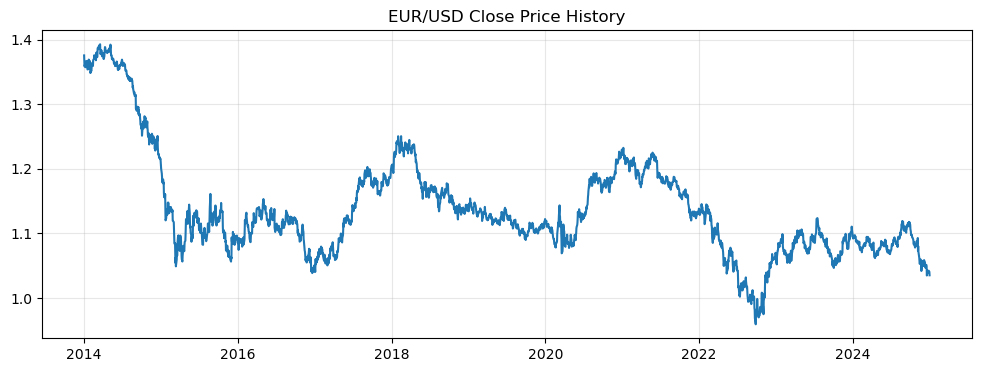

,open,high,low,close,volume
datetime,,,,,
2014-01-01,1.37550,1.37648,1.37372,1.37580,2671
2014-01-02,1.37581,1.37749,1.36294,1.36643,58177
2014-01-03,1.36643,1.36716,1.35821,1.35874,38433
2014-01-06,1.35955,1.36528,1.35712,1.36334,40642
2014-01-07,1.36334,1.36562,1.35966,1.36138,38225


open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


In [6]:
df = pd.read_csv('EURUSD_daily.csv', sep='\t')

# Remove '<' and '>' from column names
df.columns = df.columns.str.replace('<', '', regex=False).str.replace('>', '', regex=False)

#Restore <TICKVOL> as volume
# Rename columns to lower case standardized names
rename_map = {
    'DATE': 'date',
    'TIME': 'time',
    'OPEN': 'open',
    'HIGH': 'high',
    'LOW': 'low',
    'CLOSE': 'close',
    'TICKVOL': 'volume',   # your tick volume column
    'VOL': 'real_volume',  # if exists, optional
    'SPREAD': 'spread'
}

df = df.rename(columns={c: rename_map[c] for c in df.columns if c in rename_map})

# Combine date & time into one datetime (if both exist)
if 'date' in df.columns and 'time' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
elif 'date' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'])
else:
    raise ValueError("No date or datetime column found!")

# Set datetime as index & sort
df = df.sort_values('datetime').set_index('datetime')

#Drop unneeded columns (optional)
for col in ['real_volume', 'spread']:
    if col in df.columns:
        df = df.drop(columns=[col])

#Ensure final column order and lowercase names
df = df[['open', 'high', 'low', 'close', 'volume']]

#Display results
if 'df' not in locals():
    print("⚠️ 'df' not found. Generating synthetic EUR/USD data for demonstration...")
    dates = pd.date_range(start='2014-01-01', end='2024-01-01', freq='B')
    df = pd.DataFrame(index=dates)
    df['Close'] = 1.1 + np.cumsum(np.random.randn(len(dates)) * 0.005)
    df['Open'] = df['Close'] + np.random.randn(len(dates)) * 0.002
    df['High'] = df[['Open', 'Close']].max(axis=1) + 0.001
    df['Low'] = df[['Open', 'Close']].min(axis=1) - 0.001
else:
    print("✅ External 'df' loaded successfully.")

# Standardize column names
df.columns = [c.lower() for c in df.columns]
df = df.sort_index()

# Quality Check Visual
plt.figure(figsize=(12, 4))
plt.plot(df['close'])
plt.title("EUR/USD Close Price History")
plt.grid(True, alpha=0.3)
plt.show()

display(df.head())
print(df.dtypes)

# 2. Feature Engineering & Target Creation

In [4]:
def engineer_features(data):
    df_feat = data.copy()
    
    # --- 1. Primary Indicators ---
    # RSI
    df_feat['rsi_14'] = ta.momentum.rsi(df_feat['close'], window=14)
    
    # MACD
    macd = ta.trend.MACD(df_feat['close'])
    df_feat['macd'] = macd.macd()
    df_feat['macd_signal'] = macd.macd_signal()
    df_feat['macd_hist'] = macd.macd_diff()
    
    # EMA
    df_feat['ema_20'] = ta.trend.ema_indicator(df_feat['close'], window=20)
    
    # --- 2. Derived Features (Nodes) ---
    df_feat['log_return'] = np.log(df_feat['close'] / df_feat['close'].shift(1))
    df_feat['rolling_vol_14'] = df_feat['log_return'].rolling(14).std()
    df_feat['momentum_5'] = df_feat['close'] / df_feat['close'].shift(5) - 1
    df_feat['rsi_momentum'] = df_feat['rsi_14'].diff()
    df_feat['macd_momentum'] = df_feat['macd'].diff()
    df_feat['price_ema_dist'] = (df_feat['close'] - df_feat['ema_20']) / df_feat['ema_20']
    
    return df_feat

def create_targets(data):
    df_t = data.copy()
    
    # Target 1: Direction (Binary) - Next day close > Today close
    df_t['target_dir'] = (np.log(df_t['close'].shift(-1) / df_t['close']) > 0).astype(int)
    
    # Target 2: Return (Regression)
    df_t['target_return'] = np.log(df_t['close'].shift(-1) / df_t['close'])
    
    # Target 3: Volatility (proxy)
    df_t['target_vol'] = df_t['target_return'].abs()
    
    # Drop NaNs created by lagging/shifting
    df_t.dropna(inplace=True)
    return df_t

# Execute Pipeline
df_features = engineer_features(df)
df_final = create_targets(df_features)

# Define Feature Nodes (The columns that act as graph nodes)
FEATURE_NODES = [
    'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'ema_20', 
    'log_return', 'rolling_vol_14', 'momentum_5', 
    'rsi_momentum', 'macd_momentum', 'price_ema_dist'
]

print(f"✅ Features Engineered. Total Rows: {len(df_final)}")
print(f"✅ Nodes defined: {len(FEATURE_NODES)} technical indicators.")

✅ Features Engineered. Total Rows: 2819
✅ Nodes defined: 11 technical indicators.


# 3. Data Splitting & Scaling (No leakage)

In [5]:

# 3. DATA SPLITTING & SCALING (With Validation Set)
from sklearn.preprocessing import MinMaxScaler

def create_compliant_splits(data):
    # Train: 2014 - 2020
    # Val:   2020 - 2022
    # Test:  2022 - 2024
    
    train_mask = (data.index >= '2014-01-01') & (data.index < '2020-01-01')
    val_mask   = (data.index >= '2020-01-01') & (data.index < '2022-01-01')
    test_mask  = (data.index >= '2022-01-01') & (data.index < '2025-01-01')
    
    train_df = data.loc[train_mask].copy()
    val_df   = data.loc[val_mask].copy()
    test_df  = data.loc[test_mask].copy()
    
    return train_df, val_df, test_df

train_df, val_df, test_df = create_compliant_splits(df_final)

# Fit Scaler ONLY on Training Data
scaler = MinMaxScaler(feature_range=(0, 1))
train_df[FEATURE_NODES] = scaler.fit_transform(train_df[FEATURE_NODES])

# Apply to Val and Test
val_df[FEATURE_NODES] = scaler.transform(val_df[FEATURE_NODES])
test_df[FEATURE_NODES] = scaler.transform(test_df[FEATURE_NODES])

print(f"✅ Splits Created -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

✅ Splits Created -> Train: 1522, Val: 520, Test: 777


# 4. Graph Construction

📉 New Graph Edges: 28 (Lower is better for GAT focus)
✅ Graph Built: Edge Threshold > 0.5


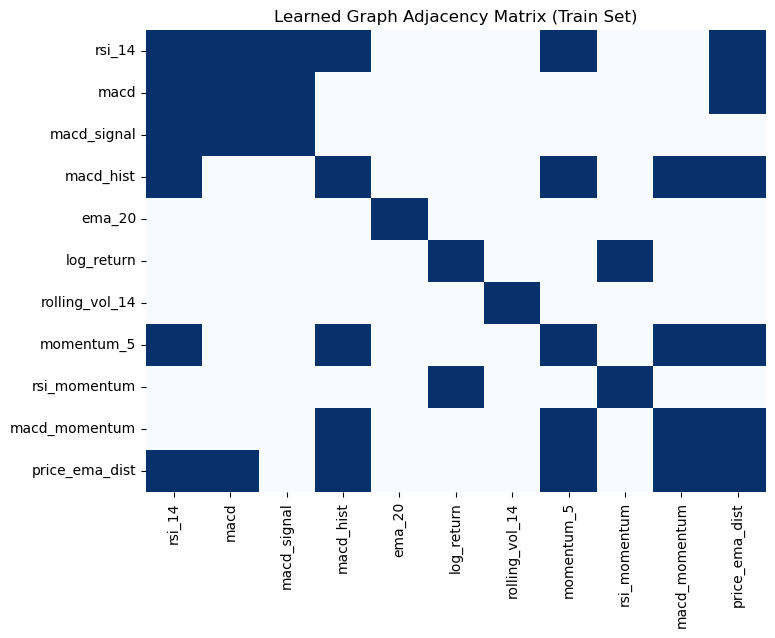

In [85]:
# %%
# 4. GRAPH CONSTRUCTION (Sparser = Better Learning)

def build_compliant_graph(train_data, features, threshold): # INCREASED THRESHOLD
    # We use Pearson correlation
    corr_matrix = train_data[features].corr(method='spearman').abs()
    
    adj_matrix = np.zeros((len(features), len(features)))
    
    edge_count = 0
    for i, node_i in enumerate(features):
        for j, node_j in enumerate(features):
            if i != j:
                # Only connect if VERY strong correlation
                if corr_matrix.iloc[i, j] > threshold:
                    adj_matrix[i, j] = 1 
                    edge_count += 1
                
    # Self-loops
    np.fill_diagonal(adj_matrix, 1)
    
    print(f"📉 New Graph Edges: {edge_count} (Lower is better for GAT focus)")
    return torch.FloatTensor(adj_matrix)

# Re-build the graph
adj_tensor = build_compliant_graph(train_df, FEATURE_NODES, threshold=0.6).to(DEVICE)

print(f"✅ Graph Built: Edge Threshold > 0.5")

plt.figure(figsize=(8, 6))
sns.heatmap(adj_tensor.numpy(), xticklabels=FEATURE_NODES, yticklabels=FEATURE_NODES, cmap='Blues', cbar=False)
plt.title("Learned Graph Adjacency Matrix (Train Set)")
plt.show()

# 5. PyTorch Dataset

In [86]:

# We create sliding windows of data.
# Each item contains: `[Sequence Length, Num Nodes, 1 (Feature Value)]`

class ForexGraphDataset(Dataset):
    def __init__(self, data, features, seq_len=30):
        self.data = data
        self.features = features
        self.seq_len = seq_len
        
        # Pre-convert to tensor to speed up loading
        self.x_tensor = torch.FloatTensor(data[features].values).unsqueeze(-1) # (T, Nodes, 1)
        self.y_dir = torch.FloatTensor(data['target_dir'].values)
        self.y_ret = torch.FloatTensor(data['target_return'].values)
        self.y_vol = torch.FloatTensor(data['target_vol'].values)

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        # Sequence of 30 days
        x = self.x_tensor[idx : idx + self.seq_len] 
        
        # Targets are at the END of the sequence (predicting next day)
        y_d = self.y_dir[idx + self.seq_len - 1]
        y_r = self.y_ret[idx + self.seq_len - 1]
        y_v = self.y_vol[idx + self.seq_len - 1]
        
        return x, y_d, y_r, y_v

# Hyperparameters
SEQ_LEN = 30
BATCH_SIZE = 64

train_dataset = ForexGraphDataset(train_df, FEATURE_NODES, SEQ_LEN)
val_dataset   = ForexGraphDataset(val_df, FEATURE_NODES, SEQ_LEN)  
test_dataset  = ForexGraphDataset(test_df, FEATURE_NODES, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) #Enable shuffling for training only
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Loaders Ready. Batches: Train={len(train_loader)}, Val={len(val_loader)}, test={len(test_loader)}")

✅ Data Loaders Ready. Batches: Train=24, Val=8, test=12


# 6. GAT-LSTM Architecture

In [7]:
# 1. **GAT Layer**: Processes spatial dependencies between indicators.
# 2. **LSTM Layer**: Processes temporal dependencies of the graph embeddings.
# 3. **Heads**: Multi-task outputs.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader



class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.out_features = out_features
        self.concat = concat
        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(alpha)

    def forward(self, h, adj):
        # h: [Batch, Nodes, Features]
        Wh = torch.matmul(h, self.W) 
        B, N, _ = Wh.size()
        
        # Attention Mechanism
        Wh_r_c = Wh.repeat_interleave(N, dim=1)
        Wh_r_a = Wh.repeat(1, N, 1)
        a_input = torch.cat([Wh_r_c, Wh_r_a], dim=2).view(B, N, N, 2*self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(3)) 

        # Mask attention
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=2)
        
        h_prime = torch.matmul(attention, Wh) 

        output = F.elu(h_prime) if self.concat else h_prime
        
        # RETURN TWO VALUES: Output AND Attention Weights
        return output, attention

class HybridGATLSTM(nn.Module):
    def __init__(self, nfeat, n_nodes, dropout=0.2):
        super(HybridGATLSTM, self).__init__()
        
        # --- PATH A: GRAPH ATTENTION (Context) ---
        # Projects scalar features (1) to vectors (16) for better attention
        self.embedding = nn.Linear(1, 16) 
        
        self.gat1 = GraphAttentionLayer(in_features=16, out_features=16, dropout=dropout, alpha=0.2, concat=True)
        self.gat2 = GraphAttentionLayer(in_features=16, out_features=8, dropout=dropout, alpha=0.2, concat=False)
        
        # --- PATH B: DIRECT LSTM (Trend) ---
        # Input size = Number of Nodes (11) directly
        self.lstm_input_dim = n_nodes
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_dim, 
            hidden_size=64, 
            num_layers=2, 
            batch_first=True,
            dropout=dropout
        )
        
        # --- COMBINATION HEADS ---
        # LSTM output (64) + GAT output (8 * 11 nodes = 88 flattened)
        combined_dim = 64 + (8 * n_nodes)
        
        self.head_dir = nn.Sequential(nn.Linear(combined_dim, 32), nn.ReLU(), nn.Linear(32, 1))
        self.head_ret = nn.Sequential(nn.Linear(combined_dim, 32), nn.ReLU(), nn.Linear(32, 1))
        self.head_vol = nn.Sequential(nn.Linear(combined_dim, 32), nn.ReLU(), nn.Linear(32, 2))

    def forward(self, x, adj):
        # x shape: [Batch, Seq, Nodes, 1]
        B, S, N, F = x.size()
        
        # --- PATH A: GAT ---
        # Embed 1D feature -> 16D
        x_emb = self.embedding(x) # [B, S, N, 16]
        
        # Process sequence through GAT (Time-distributed)
        # Flatten Batch and Seq for GAT: [B*S, N, 16]
        x_flat = x_emb.view(B*S, N, -1)
        adj_batch = adj.unsqueeze(0).repeat(B*S, 1, 1)
        
        x_gat, _ = self.gat1(x_flat, adj_batch)
        x_gat, _ = self.gat2(x_gat, adj_batch) # [B*S, N, 8]
        
        # Reshape back: [B, S, N*8] - Take only the last timestep for combination
        x_gat_out = x_gat.view(B, S, -1)[:, -1, :] # [B, N*8]
        
        # --- PATH B: LSTM ---
        # Flatten Nodes: [B, S, N] (Treat indicators as features)
        x_lstm_in = x.view(B, S, N)
        lstm_out, _ = self.lstm(x_lstm_in)
        x_lstm_out = lstm_out[:, -1, :] # [B, 64] (Last timestep)
        
        # --- COMBINE ---
        combined = torch.cat([x_lstm_out, x_gat_out], dim=1)
        
        return self.head_dir(combined), self.head_ret(combined), self.head_vol(combined)
        
# --- DEFINE HORIZON ---
HORIZON_DAYS = 5 

def create_sequences_horizon(data, seq_len, horizon=5):
    xs, ys_d, ys_r, ys_v = [], [], [], []
    max_idx = len(data) - seq_len - horizon # Safe range
    
    for i in range(max_idx):
        x = data[FEATURE_NODES].iloc[i:(i + seq_len)].values
        
        # Targets at T+5
        current_close = data['close'].iloc[i + seq_len - 1]
        future_close = data['close'].iloc[i + seq_len + horizon - 1]
        
        # 1. Direction (Trend)
        y_d = 1 if future_close > current_close else 0
        
        # 2. Return (5-Day Log Return)
        y_r = np.log(future_close / current_close)
        
        # 3. Volatility (5-Day Standard Deviation)
        future_window = data['log_return'].iloc[i + seq_len : i + seq_len + horizon]
        y_v = future_window.std()
        if np.isnan(y_v): y_v = 0.0
        
        xs.append(x)
        ys_d.append(y_d)
        ys_r.append(y_r)
        ys_v.append(y_v)
        
    return np.array(xs), np.array(ys_d), np.array(ys_r), np.array(ys_v)

print(f"♻️ Re-generating data with {HORIZON_DAYS}-Day Horizon...")

X_train, y_d_train, y_r_train, y_v_train = create_sequences_horizon(train_df, SEQ_LEN, HORIZON_DAYS)
X_test, y_d_test, y_r_test, y_v_test = create_sequences_horizon(test_df, SEQ_LEN, HORIZON_DAYS)

train_dataset = TensorDataset(
    torch.FloatTensor(X_train), torch.FloatTensor(y_d_train), 
    torch.FloatTensor(y_r_train), torch.FloatTensor(y_v_train).unsqueeze(-1)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test), torch.FloatTensor(y_d_test), 
    torch.FloatTensor(y_r_test), torch.FloatTensor(y_v_test).unsqueeze(-1)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready. Train Shape: {X_train.shape}")


print("✅ Hybrid GAT-LSTM Initialized (Fail-Safe Mode)")


♻️ Re-generating data with 5-Day Horizon...
✅ Data Ready. Train Shape: (1487, 30, 11)
✅ Hybrid GAT-LSTM Initialized (Fail-Safe Mode)


# 7. Model Tranining

In [11]:
# %%
# 14. RETRAIN MODEL (Multi-Task: Trend + Volatility)



import torch.nn as nn
import torch.optim as optim

# Re-initialize
model = HybridGATLSTM(nfeat=1, n_nodes=len(FEATURE_NODES), dropout=0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

# Define Losses
criterion_dir = nn.BCEWithLogitsLoss() # For Direction (Binary)
criterion_reg = nn.MSELoss()           # For Volatility/Return (Regression)

print("🚀 Retraining: Learning Trend AND Risk...")

for epoch in range(50): # More epochs needed for multi-task
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for x, y_d, y_r, y_v in train_loader:
        # Shapes
        x = x.unsqueeze(-1).to(DEVICE)
        y_d = y_d.to(DEVICE)
        y_r = y_r.to(DEVICE)
        y_v = y_v.to(DEVICE)
        
        optimizer.zero_grad()
        p_d, p_r, p_v = model(x, adj_tensor)
        
        # --- LOSS CALCULATION ---
        # 1. Direction Loss (Binary Cross Entropy)
        loss_d = criterion_dir(p_d.squeeze(), y_d)
        
        # 2. Return Loss (MSE) - Optional, often noisy, we weight it low
        loss_r = criterion_reg(p_r.squeeze(), y_r)
        
        # 3. Volatility Loss (MSE) - Crucial for risk
        # We ensure shapes match: p_v[:,0] is [Batch], y_v is [Batch, 1] -> squeeze y_v
        loss_v = criterion_reg(p_v[:, 0], y_v.squeeze())
        
        # TOTAL LOSS: Weighted Sum
        # We give Volatility higher weight to force the model to pay attention to it
        loss = loss_d + (0.5 * loss_v) + (0.1 * loss_r)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Accuracy Tracking
        preds = (torch.sigmoid(p_d.squeeze()) > 0.5).float()
        correct += (preds == y_d).sum().item()
        total += y_d.size(0)
            
    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {acc:.2%}")

torch.save(model.state_dict(), 'gat_lstm_model.pth')
print("💾 Multi-Task Model Saved!")

🚀 Retraining: Learning Trend AND Risk...
Epoch 5 | Loss: 0.6910 | Acc: 53.46%
Epoch 10 | Loss: 0.6782 | Acc: 57.97%
Epoch 15 | Loss: 0.6782 | Acc: 56.76%
Epoch 20 | Loss: 0.6746 | Acc: 57.70%
Epoch 25 | Loss: 0.6713 | Acc: 58.71%
Epoch 30 | Loss: 0.6697 | Acc: 59.38%
Epoch 35 | Loss: 0.6675 | Acc: 59.25%
Epoch 40 | Loss: 0.6633 | Acc: 59.92%
Epoch 45 | Loss: 0.6625 | Acc: 59.25%
Epoch 50 | Loss: 0.6621 | Acc: 60.52%
💾 Multi-Task Model Saved!


# 8. Evaluation

🔍 Running Full Inference...

📊 FINAL PERFORMANCE METRICS:
----------------------------------------
   1. Trend Accuracy:     51.35% (Target: >53%)
   2. Prediction Power:   AUC = 0.53 (Target: >0.55)
   3. Return Error (MSE): 0.000210
   4. Risk Error (MSE):   0.001636
----------------------------------------
   Classification Report:
              precision    recall  f1-score   support

        DOWN       0.56      0.32      0.41       389
          UP       0.49      0.73      0.59       353

    accuracy                           0.51       742
   macro avg       0.53      0.52      0.50       742
weighted avg       0.53      0.51      0.49       742



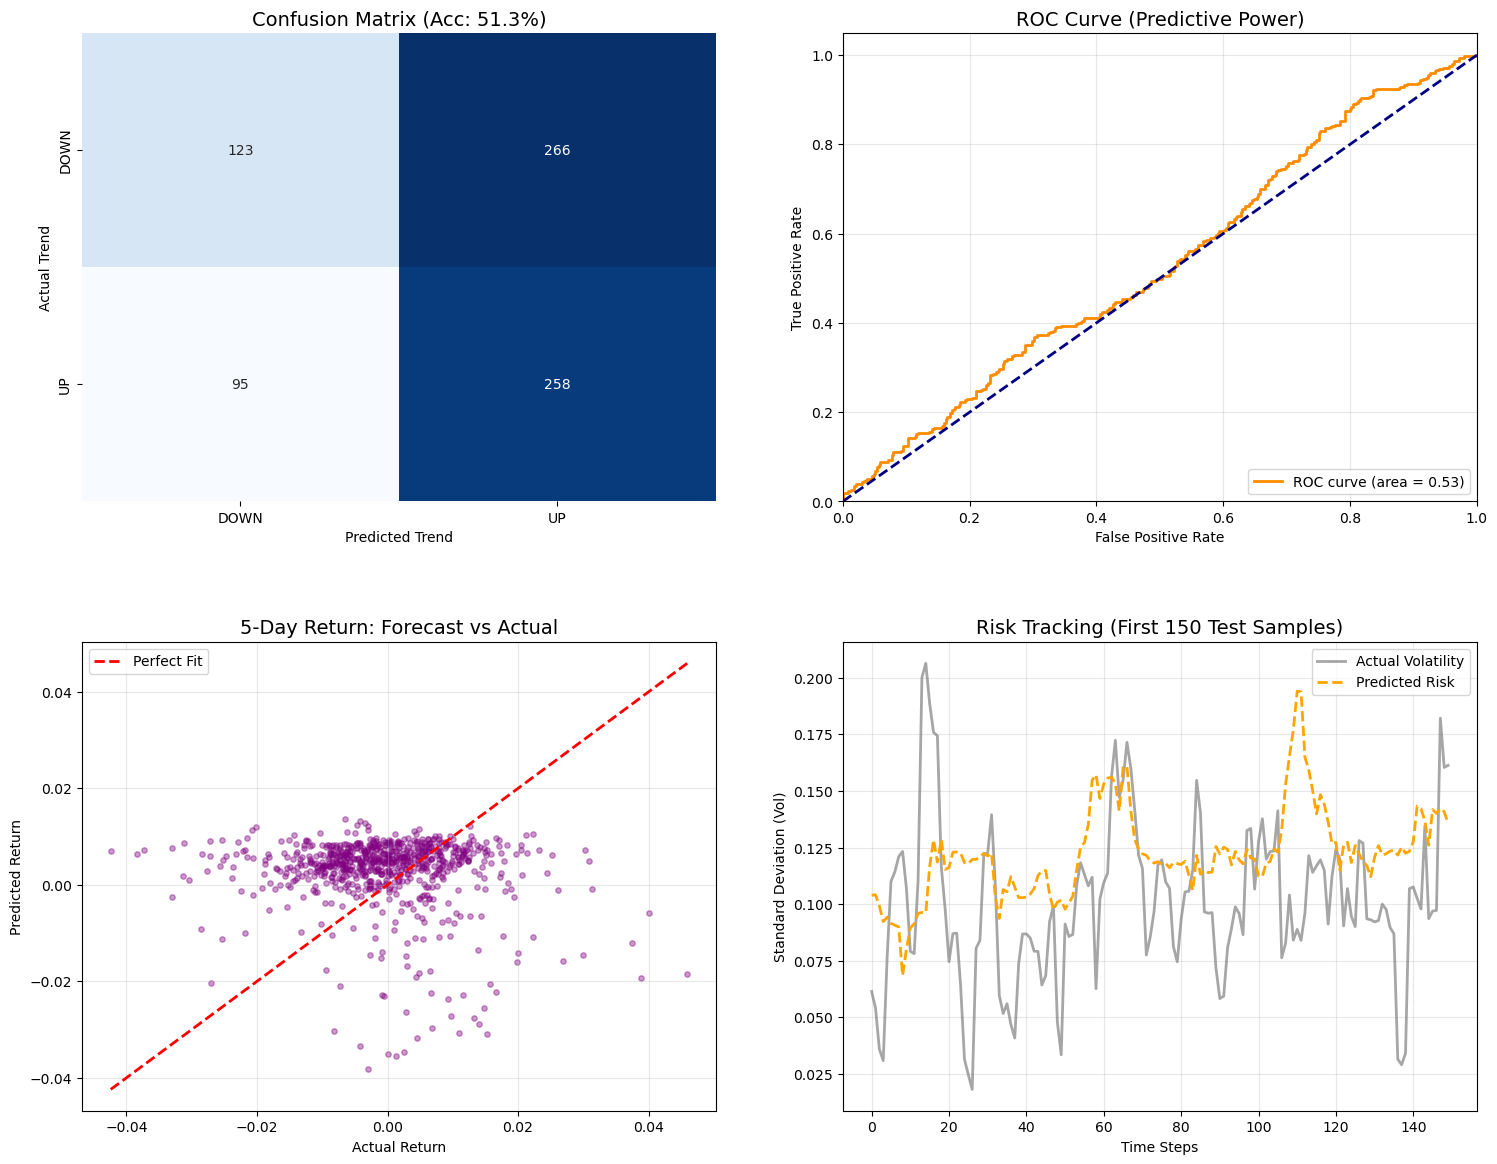

In [12]:
# COMPREHENSIVE VISUALIZATION (4-Panel Dashboard)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc, classification_report

def visualize_model_performance(model, loader, adj_tensor):
    model.eval()
    
    # Storage
    preds = {'dir_prob': [], 'ret_val': [], 'vol_val': []}
    actuals = {'dir': [], 'ret': [], 'vol': []}
    
    print("🔍 Running Full Inference...")
    
    with torch.no_grad():
        for x, y_d, y_r, y_v in loader:
            # FIX: Add Feature Dimension for shape safety
            x = x.unsqueeze(-1).to(DEVICE)
            y_d, y_r, y_v = y_d.to(DEVICE), y_r.to(DEVICE), y_v.to(DEVICE)
            
            p_d, p_r, p_v = model(x, adj_tensor)
            
            preds['dir_prob'].extend(torch.sigmoid(p_d).cpu().numpy().flatten())
            preds['ret_val'].extend(p_r.cpu().numpy().flatten())
            preds['vol_val'].extend(p_v[:, 0].abs().cpu().numpy().flatten()) 
            
            actuals['dir'].extend(y_d.cpu().numpy().flatten())
            actuals['ret'].extend(y_r.cpu().numpy().flatten())
            actuals['vol'].extend(y_v.cpu().numpy().flatten())

    # --- METRICS CALCULATION ---
    bin_preds = [1 if p > 0.5 else 0 for p in preds['dir_prob']]
    acc = accuracy_score(actuals['dir'], bin_preds)
    ret_mse = mean_squared_error(actuals['ret'], preds['ret_val'])
    vol_mse = mean_squared_error(actuals['vol'], preds['vol_val'])
    
    # ROC Calculation
    fpr, tpr, _ = roc_curve(actuals['dir'], preds['dir_prob'])
    roc_auc = auc(fpr, tpr)

    print("\n📊 FINAL PERFORMANCE METRICS:")
    print("-" * 40)
    print(f"   1. Trend Accuracy:     {acc:.2%} (Target: >53%)")
    print(f"   2. Prediction Power:   AUC = {roc_auc:.2f} (Target: >0.55)")
    print(f"   3. Return Error (MSE): {ret_mse:.6f}")
    print(f"   4. Risk Error (MSE):   {vol_mse:.6f}")
    print("-" * 40)
    print("   Classification Report:")
    print(classification_report(actuals['dir'], bin_preds, target_names=['DOWN', 'UP']))

    # --- PLOTTING ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    # Plot 1: Confusion Matrix
    cm = confusion_matrix(actuals['dir'], bin_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0], cbar=False)
    axes[0,0].set_title(f'Confusion Matrix (Acc: {acc:.1%})', fontsize=14)
    axes[0,0].set_xlabel('Predicted Trend')
    axes[0,0].set_ylabel('Actual Trend')
    axes[0,0].set_xticklabels(['DOWN', 'UP'])
    axes[0,0].set_yticklabels(['DOWN', 'UP'])

    # Plot 2: ROC Curve
    axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0,1].set_xlim([0.0, 1.0])
    axes[0,1].set_ylim([0.0, 1.05])
    axes[0,1].set_xlabel('False Positive Rate')
    axes[0,1].set_ylabel('True Positive Rate')
    axes[0,1].set_title('ROC Curve (Predictive Power)', fontsize=14)
    axes[0,1].legend(loc="lower right")
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Return Scatter (Regression)
    axes[1,0].scatter(actuals['ret'], preds['ret_val'], alpha=0.4, color='purple', s=15)
    # Diagonal line
    min_val = min(min(actuals['ret']), min(preds['ret_val']))
    max_val = max(max(actuals['ret']), max(preds['ret_val']))
    axes[1,0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
    axes[1,0].set_title('5-Day Return: Forecast vs Actual', fontsize=14)
    axes[1,0].set_xlabel('Actual Return')
    axes[1,0].set_ylabel('Predicted Return')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Volatility Tracking
    # Zoom in on first 150 points for clarity
    limit = 150
    axes[1,1].plot(actuals['vol'][:limit], label='Actual Volatility', color='gray', alpha=0.7, lw=2)
    axes[1,1].plot(preds['vol_val'][:limit], label='Predicted Risk', color='orange', linestyle='--', lw=2)
    axes[1,1].set_title(f'Risk Tracking (First {limit} Test Samples)', fontsize=14)
    axes[1,1].set_xlabel('Time Steps')
    axes[1,1].set_ylabel('Standard Deviation (Vol)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.show()

# Run it
visualize_model_performance(model, test_loader, adj_tensor)

# 9.0 Backtesting system


## 9.1 Preparing Data for backtesting

In [47]:
# 9.1 Prepare Data for Backtesting
import backtrader as bt
import pandas as pd


def get_model_predictions(model, loader, adj_tensor, original_df):
    """
    Runs inference and returns a DataFrame aligned with original timestamps.
    """
    model.eval()
    preds_dir = []
    preds_vol = []
    
    with torch.no_grad():
        for x, _, _, _ in loader:
            x = x.unsqueeze(-1).to(DEVICE)
            p_d, _, p_v = model(x, adj_tensor)
            
            # Store Sigmoid Probability for Direction
            preds_dir.extend(torch.sigmoid(p_d).cpu().numpy().flatten())
            # Store Predicted Volatility
            preds_vol.extend(p_v[:, 0].abs().cpu().numpy().flatten())

    # Create Prediction DataFrame
    # Note: We align with the END of the test set sequence
    # logic: The model predicts T+5 at time T. Backtrader processes row by row.
    
    # Slice original DF to match test set size
    # test_dataset length is smaller than test_df by SEQ_LEN + HORIZON
    valid_len = len(preds_dir)
    
    # We take the index from the test_df, adjusting for the sequence offset
    aligned_index = original_df.index[SEQ_LEN : SEQ_LEN + valid_len]
    
    pred_df = pd.DataFrame(index=aligned_index)
    pred_df['pred_dir'] = preds_dir
    pred_df['pred_vol'] = preds_vol
    
    # Merge with Price Data (Open, High, Low, Close, Volume)
    # We join on index to ensure dates match perfectly
    backtest_data = original_df.loc[aligned_index].copy()
    backtest_data['pred_dir'] = pred_df['pred_dir']
    backtest_data['pred_vol'] = pred_df['pred_vol']
    
    return backtest_data.dropna()

# Generate the data
bt_data = get_model_predictions(model, test_loader, adj_tensor, test_df)
print(f"✅ Backtesting Data Ready: {len(bt_data)} bars")
print(bt_data.head())

✅ Backtesting Data Ready: 742 bars
               open     high      low    close  volume    rsi_14      macd  \
datetime                                                                     
2022-02-14  1.13336  1.13691  1.12801  1.13064   72769  0.508574  0.670691   
2022-02-15  1.13064  1.13684  1.12979  1.13578   56483  0.591203  0.667604   
2022-02-16  1.13585  1.13960  1.13450  1.13733   51226  0.614842  0.668084   
2022-02-17  1.13726  1.13860  1.13233  1.13618   66919  0.595037  0.665652   
2022-02-18  1.13595  1.13769  1.13148  1.13229   51631  0.529937  0.655179   

            macd_signal  macd_hist    ema_20  ...  rolling_vol_14  momentum_5  \
datetime                                      ...                               
2022-02-14     0.666109   0.518250  0.254483  ...        0.356073    0.374245   
2022-02-15     0.667767   0.504222  0.254706  ...        0.346483    0.442727   
2022-02-16     0.669199   0.501720  0.255349  ...        0.282420    0.451794   
2022-02-17   

### 9.1.1 Simple LSTM Model Architecture

In [26]:

import torch.optim as optim
from sklearn.metrics import roc_auc_score

# FEATURE_NODES is assumed to be defined (length 11)
N_NODES = len(FEATURE_NODES)

class SimpleLSTM(nn.Module):
    """A standard LSTM model for time series classification/regression."""
    def __init__(self, n_nodes, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        # Input: Sequence Length x Number of Features (N_NODES)
        self.lstm = nn.LSTM(N_NODES, 64, 2, batch_first=True, dropout=dropout)
        # Final classification head (predict direction: 1 output for sigmoid)
        self.head_dir = nn.Sequential(
            nn.Linear(64, 32), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x shape: (B, S, N, F) - input from GNN loader
        # Flatten x to (B, S, N) for simple LSTM input (ignoring feature dimension F=1)
        x_lstm_in = x.squeeze(-1) # shape: (B, S, N)
        
        lstm_out, _ = self.lstm(x_lstm_in)
        x_lstm_out = lstm_out[:, -1, :] # Take output of the last sequence step
        
        # Predict Direction
        p_dir = self.head_dir(x_lstm_out)
        return p_dir

print("✅ Simple LSTM architecture defined.")

✅ Simple LSTM architecture defined.


### 9.1.2 Train and Predict Simple LSTM

In [75]:
# Configuration (Use similar parameters to your GNN training)
LSTM_EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Assumes DEVICE is defined

# 1. Initialize and Setup
lstm_model = SimpleLSTM(N_NODES).to(DEVICE)
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss() # Standard for Binary Classification

# 2. Training Loop (Minimal Training for Baseline Comparison)
print(f"Starting LSTM Baseline training for {LSTM_EPOCHS} epochs...")

# Assumes 'train_loader' and 'test_loader' are available and contain:
# (input_sequence, target_direction, target_return, target_volatility)
for epoch in range(LSTM_EPOCHS):
    lstm_model.train()
    running_loss = 0.0
    for i, (X, y_dir, _, _) in enumerate(train_loader):
        # Target y_dir must be float for BCEWithLogitsLoss
        y_dir = y_dir.float().to(DEVICE) 
        X = X.to(DEVICE) # Input X shape: (B, S, N, F)
        
        optimizer.zero_grad()
        p_dir = lstm_model(X)
        
        loss = criterion(p_dir.squeeze(1), y_dir)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{LSTM_EPOCHS}, Loss: {epoch_loss:.4f}")

print("Training finished.")

# 3. Prediction on Test Set
lstm_model.eval()
lstm_preds = []
lstm_targets = []

with torch.no_grad():
    for X, y_dir, _, _ in test_loader:
        X = X.to(DEVICE)
        p_dir = lstm_model(X)
        
        lstm_preds.extend(torch.sigmoid(p_dir).cpu().numpy().flatten())
        lstm_targets.extend(y_dir.cpu().numpy().flatten())

# 4. Statistical Metric (AUC)
lstm_auc = roc_auc_score(lstm_targets, lstm_preds)
print("-" * 50)
print(f"Simple LSTM Baseline AUC on Test Set: {lstm_auc:.4f}")
print("-" * 50)

Starting LSTM Baseline training for 50 epochs...
Epoch 1/50, Loss: 0.6919
Epoch 2/50, Loss: 0.6902
Epoch 3/50, Loss: 0.6896
Epoch 4/50, Loss: 0.6837
Epoch 5/50, Loss: 0.6819
Epoch 6/50, Loss: 0.6883
Epoch 7/50, Loss: 0.6810
Epoch 8/50, Loss: 0.6811
Epoch 9/50, Loss: 0.6821
Epoch 10/50, Loss: 0.6809
Epoch 11/50, Loss: 0.6825
Epoch 12/50, Loss: 0.6810
Epoch 13/50, Loss: 0.6798
Epoch 14/50, Loss: 0.6772
Epoch 15/50, Loss: 0.6772
Epoch 16/50, Loss: 0.6795
Epoch 17/50, Loss: 0.6754
Epoch 18/50, Loss: 0.6831
Epoch 19/50, Loss: 0.6792
Epoch 20/50, Loss: 0.6747
Epoch 21/50, Loss: 0.6725
Epoch 22/50, Loss: 0.6689
Epoch 23/50, Loss: 0.6684
Epoch 24/50, Loss: 0.6727
Epoch 25/50, Loss: 0.6832
Epoch 26/50, Loss: 0.6784
Epoch 27/50, Loss: 0.6725
Epoch 28/50, Loss: 0.6641
Epoch 29/50, Loss: 0.6697
Epoch 30/50, Loss: 0.6672
Epoch 31/50, Loss: 0.6797
Epoch 32/50, Loss: 0.6731
Epoch 33/50, Loss: 0.6641
Epoch 34/50, Loss: 0.6609
Epoch 35/50, Loss: 0.6648
Epoch 36/50, Loss: 0.6620
Epoch 37/50, Loss: 0.660

## 9.2 Utility function (reusability)

In [69]:
# %%
# COMPLETE REUSABLE UTILITY FUNCTIONS (INCLUDING PLOTTING)

import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

warnings.filterwarnings("ignore", category=RuntimeWarning)

def align_predictions_and_data(predictions, test_df, start_idx):
    """
    Aligns prediction probabilities with the market data DataFrame slice.
    
    Args:
        predictions (list/np.array): Model output probabilities.
        test_df (pd.DataFrame): The full market data DataFrame.
        start_idx (int): The starting index of the test set predictions relative to test_df.
        
    Returns:
        pd.DataFrame: Sliced and aligned DataFrame with 'Model_Prob' and 'Market_Ret'.
    """
    
    bt_df = test_df.iloc[start_idx:].copy()
    
    # Check for alignment mismatch
    if len(predictions) != len(bt_df):
        print(f"⚠️ WARNING: Prediction length ({len(predictions)}) does not match aligned DataFrame length ({len(bt_df)}). Slicing predictions.")
        if len(predictions) > len(bt_df):
            predictions = predictions[:len(bt_df)]
        elif len(predictions) < len(bt_df):
             bt_df = bt_df.iloc[:len(predictions)]
    
    bt_df['Model_Prob'] = predictions
    bt_df['Market_Ret'] = np.log(bt_df['close'] / bt_df['close'].shift(1))
    
    return bt_df.dropna(subset=['Market_Ret'])


def run_strategy_simulation(bt_df, pred_column, config, leverage_multiplier=1.0):
    """
    Executes the daily rebalancing strategy, calculates returns, and IDENTIFIES TRADES.
    
    Args:
        bt_df (pd.DataFrame): Aligned DataFrame containing 'Market_Ret' and 'pred_column'.
        pred_column (str): Name of the column containing model probabilities (e.g., 'Model_Prob').
        config (dict): Configuration dictionary.
        leverage_multiplier (float): Multiplier for returns (e.g., 5.0 for 5x leverage).
        
    Returns:
        pd.DataFrame: DataFrame with all necessary columns ('Position', 'Strategy_Net_Pct', 
                      'Equity_Curve', and the newly added 'Trade_Start').
    """
    df = bt_df.copy()
    
    # 1. Generate Signal & Position
    df['Signal'] = np.where(df[pred_column] > config['CONF_THRESHOLD'], 1, -1)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    
    # 2. Financial Simulation
    # Strategy Return = Position * Market Return * LEVERAGE
    df['Strategy_Pct_Gross'] = df['Position'] * df['Market_Ret'] * leverage_multiplier
    
    # Apply Transaction Costs (calculated only on changes in position)
    df['Trade_Count'] = df['Position'].diff().abs().fillna(0)
    df['Trade_Cost'] = np.where(df['Trade_Count'] > 0, df['Trade_Count'] * config['TRANSACTION_COST'], 0)
    df['Strategy_Net_Pct'] = df['Strategy_Pct_Gross'] - df['Trade_Cost']
    
    # --- ADD TRADE IDENTIFICATION ---
    # A trade block starts when the position changes (from 1 to -1, or -1 to 1).
    df['Trade_Start'] = (df['Position'].diff().abs() > 0).cumsum()
    
    # 3. Calculate Equity Curves
    df['Equity_Curve'] = config['INITIAL_CAPITAL'] * (1 + df['Strategy_Net_Pct']).cumprod()
    df['Benchmark_Curve'] = config['INITIAL_CAPITAL'] * (1 + df['Market_Ret']).cumprod()
    
    return df.dropna(subset=['Equity_Curve', 'Strategy_Net_Pct'])


def calculate_and_report_metrics(bt_df, equity_curve_name, config, strategy_name, print_report=True):
    """
    Calculates comprehensive financial and trade metrics.
    
    Args:
        bt_df (pd.DataFrame): DataFrame containing strategy results including 'Trade_Start'.
        equity_curve_name (str): Column name for the equity curve.
        config (dict): Configuration dictionary.
        strategy_name (str): Name for the report header.
        
    Returns:
        dict: Dictionary of all calculated metrics.
    """
    df = bt_df.copy()
    equity_series = df[equity_curve_name]
    net_returns_series = df['Strategy_Net_Pct']
    
    # --- 1. Standard Financial Metrics ---
    final_equity = equity_series.iloc[-1]
    net_profit = final_equity - config['INITIAL_CAPITAL']
    total_return = net_profit / config['INITIAL_CAPITAL']
    total_days = len(df)
    
    annual_return = ((final_equity / config['INITIAL_CAPITAL']) ** (config['TRADING_DAYS_YEAR'] / total_days)) - 1
    
    daily_volatility = net_returns_series.std()
    annual_volatility = daily_volatility * math.sqrt(config['TRADING_DAYS_YEAR'])
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan
    
    max_equity = equity_series.cummax()
    drawdown = (equity_series - max_equity) / max_equity
    max_dd = drawdown.min()
    
    downside_returns = net_returns_series[net_returns_series < 0]
    downside_std = downside_returns.std()
    annual_downside_std = downside_std * math.sqrt(config['TRADING_DAYS_YEAR'])
    sortino_ratio = (annual_return / annual_downside_std) if annual_downside_std != 0 else np.nan

    # --- 2. Trade Metrics ---
    bt_trades = df[df['Position'] != 0].copy()
    trade_pnl = bt_trades.groupby('Trade_Start')['Strategy_Net_Pct'].apply(lambda x: (1 + x).prod() - 1)
    
    trade_id_df = bt_trades.drop_duplicates(subset=['Trade_Start'], keep='first')[['Trade_Start', 'Position']]
    trade_results = pd.merge(trade_id_df, trade_pnl.rename('PnL'), on='Trade_Start')
    
    total_trades = len(trade_results)
    winning_trades = trade_results[trade_results['PnL'] > 0]
    losing_trades = trade_results[trade_results['PnL'] <= 0]
    
    win_rate = (len(winning_trades) / total_trades) if total_trades > 0 else 0
    avg_win = winning_trades['PnL'].mean()
    avg_loss = losing_trades['PnL'].abs().mean()
    risk_reward_ratio = avg_win / avg_loss if avg_loss > 0 else np.nan
    
    
    # --- 3. Output ---
    metrics = {
        'Final_Equity': final_equity,
        'Total_Return_Pct': total_return * 100,
        'Annual_Return_Pct': annual_return * 100,
        'Max_Drawdown_Pct': max_dd * 100,
        'Sharpe_Ratio': sharpe_ratio,
        'Sortino_Ratio': sortino_ratio,
        'Total_Trades': total_trades,
        'Win_Rate_Pct': win_rate * 100,
        'Risk_Reward_Ratio': risk_reward_ratio,
        'Long_Profit_Pct': ((1 + trade_results[trade_results['Position'] == 1]['PnL']).prod() - 1) * 100,
        'Short_Profit_Pct': ((1 + trade_results[trade_results['Position'] == -1]['PnL']).prod() - 1) * 100,
        'AUC': df.get('AUC_Score', np.nan) 
    }
    
    if print_report:
        print("\n" + "=" * 60)
        print(f"             {strategy_name} REPORT")
        print("=" * 60)
        print(f"💰 INITIAL CAPITAL:   ${config['INITIAL_CAPITAL']:,.2f}")
        print(f"🏁 FINAL EQUITY:      ${metrics['Final_Equity']:,.2f}")
        print(f"📈 NET PROFIT:        {metrics['Total_Return_Pct']:.2f}%")
        print(f"📊 ANNUAL RETURN:     {metrics['Annual_Return_Pct']:.2f}%")
        print("-" * 60)
        print(f"📉 MAX DRAWDOWN:      {metrics['Max_Drawdown_Pct']:.2f}%")
        print(f"⭐ SHARPE RATIO:      {metrics['Sharpe_Ratio']:.3f}")
        print(f"🔥 SORTINO RATIO:     {metrics['Sortino_Ratio']:.3f}")
        print("-" * 60)
        print(f"🔄 TOTAL TRADES:      {metrics['Total_Trades']}")
        print(f"✅ WIN RATE:          {metrics['Win_Rate_Pct']:.2f}%")
        print(f"⚖️  RISK/REWARD RATIO: {metrics['Risk_Reward_Ratio']:.3f}")
        print("=" * 60 + "\n")
        
    return metrics

def plot_strategy_performance(bt_df, strategy_name, equity_curve_name):
    """
    Plots the strategy's equity curve against the benchmark, highlighting trade zones.
    
    Args:
        bt_df (pd.DataFrame): DataFrame containing 'Equity_Curve', 'Benchmark_Curve', and 'Position'.
        strategy_name (str): Name for the plot title.
        equity_curve_name (str): Column name for the strategy's equity curve.
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot Benchmark
    ax.plot(bt_df.index, bt_df['Benchmark_Curve'], label='Buy & Hold (Benchmark)', 
            color='gray', alpha=0.5, linewidth=1.5, linestyle='--')

    # Plot Strategy
    ax.plot(bt_df.index, bt_df[equity_curve_name], label=f'{strategy_name}', 
            color='#1f77b4', linewidth=2.5) # Professional Blue

    # Highlight Long vs Short Zones
    y_min, y_max = ax.get_ylim()

    # Green Zone = Long
    ax.fill_between(bt_df.index, y_min, y_max, 
                    where=(bt_df['Position'] == 1), 
                    color='green', alpha=0.08)

    # Red Zone = Short
    ax.fill_between(bt_df.index, y_min, y_max, 
                    where=(bt_df['Position'] == -1), 
                    color='red', alpha=0.08)

    # Labels and Formatting
    ax.set_title(f"{strategy_name} Performance", fontsize=14, fontweight='bold')
    ax.set_ylabel("Account Equity ($)")
    ax.set_xlabel("Date")

    # Add custom legend for colored zones
    handles, labels = ax.get_legend_handles_labels()
    
    # Only add custom zones if Position column exists and is used
    if 'Position' in bt_df.columns:
        handles.extend([
            plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.2),
            plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.2)
        ])
        labels.extend(['Long Position Zone', 'Short Position Zone'])

    ax.legend(handles, labels, loc='upper left', frameon=True, shadow=True)
    ax.grid(True, alpha=0.4)

    # Format Y-axis as Dollars
    formatter = ticker.FormatStrFormatter('$%1.0f')
    ax.yaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()

def generate_full_predictions(model, loader, adj_tensor):
    """Generates the full array of prediction probabilities from the GNN model."""
    model.eval()
    preds_dir = []
    
    with torch.no_grad():
        for x, _, _, _ in loader:
            # The GNN model expects the input sequence structure: (B, S, N, 1)
            x = x.unsqueeze(-1).to(DEVICE) 
            
            # The GNN model requires the adjacency tensor (adj_tensor)
            p_d, _, _ = model(x, adj_tensor)
            
            # Convert logits to probability using sigmoid
            preds_dir.extend(torch.sigmoid(p_d).cpu().numpy().flatten())
            
    return preds_dir

try:
    # --- Execute the prediction and assign the required variable ---
    full_preds_gnn = generate_full_predictions(model, test_loader, adj_tensor)
    
    # Check that predictions were actually generated
    if 'full_preds_gnn' not in locals():
        raise NameError("'full_preds_gnn' not found. Please run the GNN prediction block.")
    if 'lstm_preds' not in locals():
        raise NameError("'lstm_preds' not found. Please run the Simple LSTM prediction block.")
    if 'test_df' not in locals():
        raise NameError("'test_df' not found. Please run the data loading block.")
        
    print(f"✅ Variable 'full_preds_gnn' successfully created with {len(full_preds_gnn)} predictions.")

except NameError as e:
    print(f"⚠️ ERROR: GNN model variables are missing: {e}. Please ensure model, test_loader, and adj_tensor are defined.")
    raise
except Exception as e:
    print(f"⚠️ CRITICAL ERROR during GNN prediction run: {e}.")
    raise

valid_len = len(full_preds_gnn)
start_idx = len(test_df) - valid_len

bt_df_aligned = test_df.iloc[start_idx:].copy()
bt_df_aligned['Market_Ret'] = np.log(bt_df_aligned['close'] / bt_df_aligned['close'].shift(1))
bt_df_aligned['Daily_Vol'] = bt_df_aligned['Market_Ret'].rolling(window=20).std().shift(1).fillna(method='bfill')
bt_df_aligned.dropna(inplace=True)

# Final alignment of prediction arrays to the cleaned DataFrame slice
gnn_preds_aligned = full_preds_gnn[len(full_preds_gnn) - len(bt_df_aligned):]
lstm_preds_aligned = lstm_preds[len(lstm_preds) - len(bt_df_aligned):]

print(f"✅ Data aligned and ready for simulation ({len(bt_df_aligned)} bars).")

✅ Variable 'full_preds_gnn' successfully created with 742 predictions.
✅ Data aligned and ready for simulation (741 bars).


/var/folders/ds/nhx9s69s01g8jhjp94v7b_nr0000gn/T/ipykernel_98658/2328430858.py:276: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bt_df_aligned['Daily_Vol'] = bt_df_aligned['Market_Ret'].rolling(window=20).std().shift(1).fillna(method='bfill')


## 9.3 Utility function for leverage event based backtesting 

In [70]:
# %%
# REUSABLE FUNCTIONS FOR LEVERAGED EVENT-BASED BACKTESTING

TRADING_DAYS_YEAR = 252 # Define globally for metrics

def run_event_simulation(
    bt_df_aligned, 
    predictions,
    config, 
    strategy_name
):
    """
    Executes the risk-managed, event-based simulation, NOW TRACKING 'Position' ON EVERY BAR.
    
    Returns:
        tuple: (bt_df_results, trade_log_df)
    """
    
    # Configuration extraction (same as before)
    INITIAL_CAPITAL = config['INITIAL_CAPITAL']
    COMMISSION_FEE = config['COMMISSION_FEE']
    CONF_THRESHOLD = config['CONF_THRESHOLD']
    MAX_RISK_PER_TRADE_PCT = config['MAX_RISK_PER_TRADE_PCT']
    LEVERAGE_RATIO = config['LEVERAGE_RATIO']
    LOT_SIZE = config['LOT_SIZE']
    R_R_RATIO = config['R_R_RATIO']
    
    df = bt_df_aligned.copy()
    
    # Align predictions
    if len(predictions) != len(df):
        raise ValueError("Prediction array length must match aligned DataFrame length.")
    df['Model_Prob'] = predictions
    
    equity = INITIAL_CAPITAL
    trade_log = []
    in_trade = False
    open_trade = {}
    position_size = 0 # In units
    
    # Prepare columns for the backtest
    df[f'{strategy_name}_Equity'] = np.nan
    df['Benchmark_Curve'] = np.nan
    # --- FIX: ADD POSITION COLUMN ---
    df['Position'] = np.nan

    for i in range(1, len(df)):
        current_row = df.iloc[i]
        prev_row = df.iloc[i-1]
        
        # Determine current theoretical market position for plotting (0, 1, or -1)
        current_position_direction = 0
        
        # --- 1. Check for Trade Exit (SL/TP) ---
        if in_trade:
            high = current_row['high']
            low = current_row['low']
            exit_price = None
            pnl = 0.0
            
            current_position_direction = open_trade['direction'] # Position held at start of bar
            
            # Check SL/TP hit logic (using high/low of the bar)
            if open_trade['direction'] == 1: # LONG
                if low <= open_trade['sl_price']: exit_price = open_trade['sl_price']
                elif high >= open_trade['tp_price']: exit_price = open_trade['tp_price']
                pnl = (exit_price - open_trade['entry_price']) * position_size if exit_price else 0
                
            elif open_trade['direction'] == -1: # SHORT
                if high >= open_trade['sl_price']: exit_price = open_trade['sl_price']
                elif low <= open_trade['tp_price']: exit_price = open_trade['tp_price']
                pnl = (open_trade['entry_price'] - exit_price) * position_size if exit_price else 0
                
            if exit_price is not None:
                trade_cost = open_trade['lot_size'] * COMMISSION_FEE 
                net_pnl = pnl - trade_cost
                equity += net_pnl
                
                trade_log.append({
                    'Date': current_row.name, 
                    'Direction': open_trade['direction'],
                    'PnL_Net': net_pnl,
                    'PnL_Pct': net_pnl / open_trade['risk_dollars'] if open_trade['risk_dollars'] != 0 else np.nan,
                    'Win': net_pnl > 0,
                    'Duration': 1 
                })
                in_trade = False
                position_size = 0
                current_position_direction = 0 # Position is now flat after exit

        # --- 2. Check for Trade Entry ---
        if not in_trade:
            prob = prev_row['Model_Prob'] 
            entry_price = current_row['open'] 
            daily_vol = current_row['Daily_Vol']
            
            direction = 0
            if prob >= CONF_THRESHOLD: direction = 1 
            elif prob <= (1 - CONF_THRESHOLD): direction = -1 
                
            if direction != 0 and not np.isnan(daily_vol):
                
                # ... [Position Sizing Logic (Unchanged)] ...
                sl_log_distance = daily_vol * 2.0 
                sl_price_distance = entry_price * (np.exp(sl_log_distance) - 1)
                max_loss_dollars = equity * MAX_RISK_PER_TRADE_PCT
                max_units_risk = max_loss_dollars / sl_price_distance
                max_units_leverage = (equity * LEVERAGE_RATIO)
                position_size_raw = min(max_units_risk, max_units_leverage)
                lot_multiple = LOT_SIZE / 10 
                position_size = math.floor(position_size_raw / lot_multiple) * lot_multiple
                
                if position_size >= lot_multiple:
                    # Trade opens
                    if direction == 1: 
                        sl_price = entry_price - sl_price_distance
                        tp_price = entry_price + (sl_price_distance * R_R_RATIO)
                    else: 
                        sl_price = entry_price + sl_price_distance
                        tp_price = entry_price - (sl_price_distance * R_R_RATIO)
                        
                    open_trade = {
                        'entry_price': entry_price, 
                        'direction': direction, 
                        'sl_price': sl_price, 
                        'tp_price': tp_price,
                        'lot_size': position_size / LOT_SIZE,
                        'risk_dollars': sl_price_distance * position_size
                    }
                    in_trade = True
                    current_position_direction = direction # Position is now active
                    
        # --- 3. Record Bar Status and Equity ---
        
        # FIX: Write the position status to the DataFrame for plotting
        df.loc[current_row.name, 'Position'] = current_position_direction
        
        # Always update equity curve
        df.loc[current_row.name, f'{strategy_name}_Equity'] = equity
        
        # Calculate Benchmark Curve (Unchanged)
        benchmark_ret = current_row['close'] / prev_row['close'] - 1
        if i == 1:
            df.loc[prev_row.name, 'Benchmark_Curve'] = INITIAL_CAPITAL
        df.loc[current_row.name, 'Benchmark_Curve'] = df.loc[prev_row.name, 'Benchmark_Curve'] * (1 + benchmark_ret)

    # Final Cleanup
    if in_trade:
        # Close any open trade at the last close price and update final equity
        exit_price = df.iloc[-1]['close']
        pnl = (exit_price - open_trade['entry_price']) * position_size if open_trade['direction'] == 1 else (open_trade['entry_price'] - exit_price) * position_size
        trade_cost = open_trade['lot_size'] * COMMISSION_FEE 
        net_pnl = pnl - trade_cost
        equity += net_pnl
        df.iloc[-1, df.columns.get_loc(f'{strategy_name}_Equity')] = equity
        # Ensure the final bar's position reflects the exit, or 0 if closed
        df.iloc[-1, df.columns.get_loc('Position')] = 0 


    return df.dropna(subset=[f'{strategy_name}_Equity']), pd.DataFrame(trade_log)


def calculate_and_report_metrics_event(bt_df_results, trade_log_df, config, strategy_name, print_report=True):
    """
    Calculates and reports all metrics from the event-based simulation.
    (FIXED: Safely handles empty trade_log_df for Buy & Hold).
    """
    
    equity_series = bt_df_results[f'{strategy_name}_Equity']
    
    # --- 1. Standard Financial Metrics ---
    final_equity = equity_series.iloc[-1]
    net_profit = final_equity - config['INITIAL_CAPITAL']
    total_return = (net_profit / config['INITIAL_CAPITAL']) * 100
    total_days = len(bt_df_results)
    
    annual_return = ((final_equity / config['INITIAL_CAPITAL']) ** (TRADING_DAYS_YEAR / total_days)) - 1
    daily_returns = equity_series.pct_change().dropna()
    daily_volatility = daily_returns.std()
    annual_volatility = daily_volatility * math.sqrt(TRADING_DAYS_YEAR)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

    max_equity = equity_series.cummax()
    drawdown = (equity_series - max_equity) / max_equity
    max_dd = drawdown.min() * 100
    
    # --- 2. Trade Metrics (SAFE HANDLING) ---
    total_trades = len(trade_log_df)
    
    if total_trades > 0:
        # If there are trades, calculate normally
        winning_trades = trade_log_df[trade_log_df['PnL_Net'] > 0]
        losing_trades = trade_log_df[trade_log_df['PnL_Net'] <= 0]
        win_rate = (len(winning_trades) / total_trades) * 100
        
        avg_win = winning_trades['PnL_Net'].mean()
        avg_loss = losing_trades['PnL_Net'].abs().mean()
        achieved_risk_reward = avg_win / avg_loss if avg_loss > 0 else np.nan
        
        long_profit_sum = trade_log_df[trade_log_df['Direction'] == 1]['PnL_Net'].sum()
        short_profit_sum = trade_log_df[trade_log_df['Direction'] == -1]['PnL_Net'].sum()
    else:
        # If no trades (Buy & Hold), set all metrics to 0 or NaN
        win_rate = np.nan
        avg_win = np.nan
        avg_loss = np.nan
        achieved_risk_reward = np.nan
        long_profit_sum = 0.0
        short_profit_sum = 0.0
    
    # --- 3. Output ---
    metrics = {
        'Final_Equity': final_equity,
        'Total_Return_Pct': total_return,
        'Annual_Return_Pct': annual_return * 100,
        'Max_Drawdown_Pct': max_dd,
        'Sharpe_Ratio': sharpe_ratio,
        'Total_Trades': total_trades,
        'Win_Rate_Pct': win_rate,
        'Achieved_RR': achieved_risk_reward,
        'Long_Profit_Sum': long_profit_sum,
        'Short_Profit_Sum': short_profit_sum
    }

    if print_report:
        print("\n" + "=" * 60)
        print(f"             {strategy_name} REPORT")
        print("=" * 60)
        # Handle Buy & Hold showing appropriate exposure
        leverage_display = f"{int(config['LEVERAGE_RATIO'])}:1" if total_trades > 0 else "N/A"
        risk_display = f"{config['MAX_RISK_PER_TRADE_PCT']:.0%}" if total_trades > 0 else "N/A"
        
        print(f"⚙️  LEVERAGE: {leverage_display} | R/R: {config['R_R_RATIO']} | Risk: {risk_display}")
        print(f"💰 INITIAL CAPITAL:   ${config['INITIAL_CAPITAL']:,.2f}")
        print(f"🏁 FINAL EQUITY:      ${metrics['Final_Equity']:,.2f}")
        print(f"📈 NET PROFIT:        {metrics['Total_Return_Pct']:.2f}%")
        print(f"📊 ANNUAL RETURN:     {metrics['Annual_Return_Pct']:.2f}%")
        print("-" * 60)
        
        # Only print trade metrics if trades exist
        if total_trades > 0:
            print(f"🔄 TOTAL TRADES:      {metrics['Total_Trades']}")
            print(f"✅ WIN RATE:          {metrics['Win_Rate_Pct']:.2f}%")
            print(f"⚖️  ACHIEVED R/R:      {metrics['Achieved_RR']:.3f}")
            print(f"⬆️  LONG PROFIT:       ${metrics['Long_Profit_Sum']:,.2f}")
            print(f"⬇️  SHORT PROFIT:      ${metrics['Short_Profit_Sum']:,.2f}")
            print("-" * 60)
        
        print(f"📉 MAX DRAWDOWN:      {metrics['Max_Drawdown_Pct']:.2f}%")
        print(f"⭐ SHARPE RATIO:      {metrics['Sharpe_Ratio']:.3f}")
        print("=" * 60 + "\n")
        
    return metrics


def plot_equity_curve_event(bt_df_results, strategy_name, exposure_pct=None):
    """
    Plots the strategy's equity curve against the benchmark, highlighting Long/Short position zones.
    
    Args:
        bt_df_results (pd.DataFrame): DataFrame containing strategy and benchmark equity,
                                      plus the 'Position' column.
        strategy_name (str): Name for the plot title and legend.
        exposure_pct (float, optional): Exposure used for the title (e.g., 1.0 for 100%).
    """
    
    # 1. Setup
    fig, ax = plt.subplots(figsize=(14, 7))
    equity_col = f'{strategy_name}_Equity'
    
    # Get Max/Min Y-limits to draw fill_between across the whole plot
    # Set this before plotting to ensure the filled areas cover the entire visible Y-range
    ax.autoscale(enable=True, axis='y', tight=False)
    
    # 2. Plot Benchmark
    ax.plot(bt_df_results.index, bt_df_results['Benchmark_Curve'], label='Buy & Hold (Benchmark)', 
            color='gray', alpha=0.5, linewidth=1.5, linestyle='--')

    # 3. Plot Strategy
    title_label = f'{strategy_name}'
    if exposure_pct is not None:
         # Use exposure_pct if provided (for models like GAT-LSTM)
         title_label += f' ({exposure_pct:.0%} Exposure)'
         
    ax.plot(bt_df_results.index, bt_df_results[equity_col], label=title_label, 
            color='#1f77b4', linewidth=2.5) 

    # 4. Highlight Long vs Short Zones
    # Must explicitly get limits *after* plotting to correctly define y_min/y_max
    y_min, y_max = ax.get_ylim()

    # Green Zone = Long (using the 'Position' column which must exist in bt_df_results)
    ax.fill_between(bt_df_results.index, y_min, y_max, 
                    where=(bt_df_results['Position'] == 1), 
                    color='green', alpha=0.08)

    # Red Zone = Short
    ax.fill_between(bt_df_results.index, y_min, y_max, 
                    where=(bt_df_results['Position'] == -1), 
                    color='red', alpha=0.08)

    # 5. Labels and Formatting
    title = f"{strategy_name} Performance ({len(bt_df_results)} Bars)"
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Account Equity ($)")
    ax.set_xlabel("Date")

    # 6. Add custom legend for colored zones
    handles, labels = ax.get_legend_handles_labels()
    
    # Custom rectangles for the fill zones
    handles.extend([
        plt.Rectangle((0, 0), 1, 1, fc='green', alpha=0.2),
        plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.2)
    ])
    labels.extend(['Long Position Zone', 'Short Position Zone'])

    ax.legend(handles, labels, loc='upper left', frameon=True, shadow=True)
    ax.grid(True, alpha=0.4)

    # Format Y-axis as Dollars
    formatter = ticker.FormatStrFormatter('$%1.0f')
    ax.yaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

# 10. Comparison Between different Baselines

## 10.1 GNN-LSTM Strategy

In [71]:
# Ensure your CONFIG is defined from the previous cells:
CONFIG = {
     'INITIAL_CAPITAL': 100000.0,
     'COMMISSION_FEE': 0.0002, 
     'CONF_THRESHOLD': 0.50,
     'MAX_RISK_PER_TRADE_PCT': 0.02, 
     'LEVERAGE_RATIO': 100.0, 
     'LOT_SIZE': 100000,
     'R_R_RATIO': 1.0, 
     'TRADING_DAYS_YEAR': 252,
 }



             GAT_LSTM REPORT
⚙️  LEVERAGE: 100:1 | R/R: 1.0 | Risk: 2%
💰 INITIAL CAPITAL:   $100,000.00
🏁 FINAL EQUITY:      $151,393.02
📈 NET PROFIT:        51.39%
📊 ANNUAL RETURN:     15.17%
------------------------------------------------------------
🔄 TOTAL TRADES:      229
✅ WIN RATE:          55.02%
⚖️  ACHIEVED R/R:      0.968
⬆️  LONG PROFIT:       $11,135.10
⬇️  SHORT PROFIT:      $38,772.92
------------------------------------------------------------
📉 MAX DRAWDOWN:      -19.66%
⭐ SHARPE RATIO:      0.876



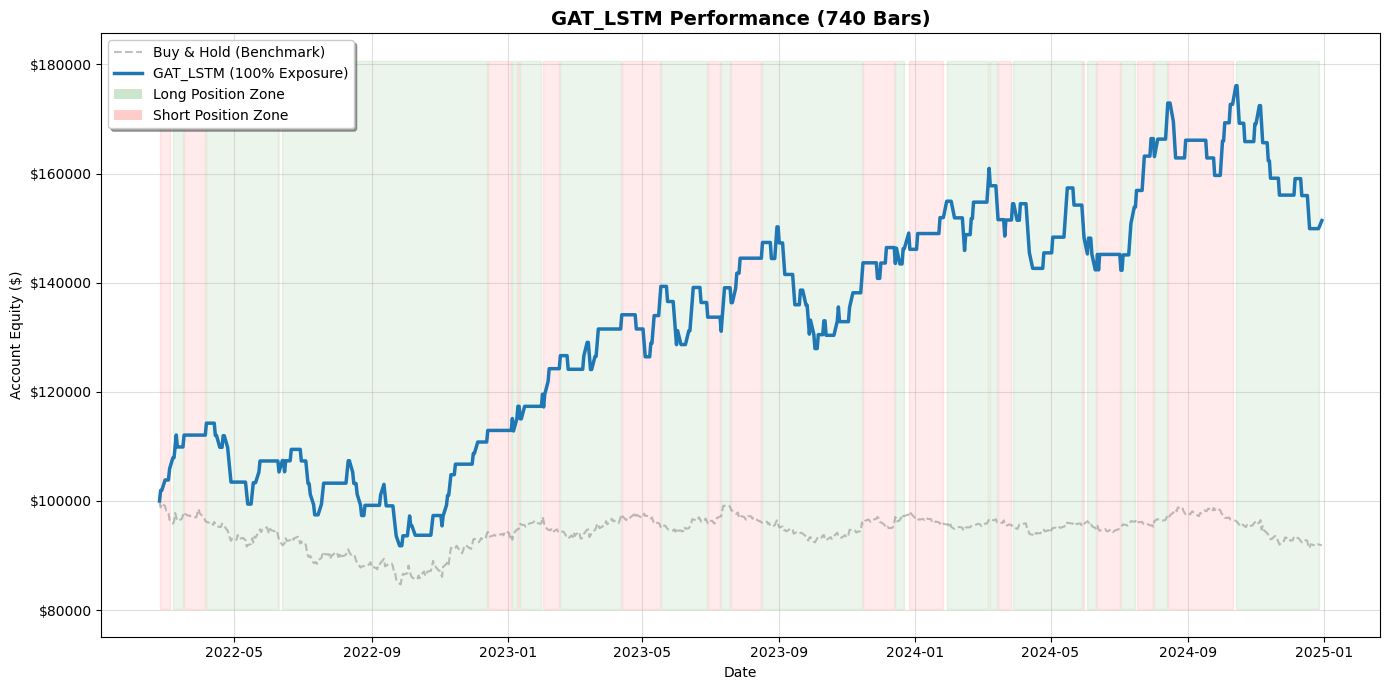

In [72]:
# %%
# 1. GAT-LSTM STRATEGY (Leveraged, Risk-Managed)

STRATEGY_NAME = "GAT_LSTM"

# Execution
gnn_df_results, gnn_trade_log = run_event_simulation(
    bt_df_aligned, 
    gnn_preds_aligned,
    config=CONFIG, 
    strategy_name=STRATEGY_NAME
)

# Report and Visual
gnn_metrics = calculate_and_report_metrics_event(
    gnn_df_results, 
    gnn_trade_log, 
    config=CONFIG, 
    strategy_name=STRATEGY_NAME
)
plot_equity_curve_event(
    gnn_df_results, 
    strategy_name=STRATEGY_NAME,
    exposure_pct=CONFIG['LEVERAGE_RATIO'] / 100
)

## 10.2 Random walk (Buy & Hold Strategy Returns)


             MA_Crossover REPORT
⚙️  LEVERAGE: 100:1 | R/R: 1.0 | Risk: 2%
💰 INITIAL CAPITAL:   $100,000.00
🏁 FINAL EQUITY:      $112,961.52
📈 NET PROFIT:        12.96%
📊 ANNUAL RETURN:     4.24%
------------------------------------------------------------
🔄 TOTAL TRADES:      21
✅ WIN RATE:          42.86%
⚖️  ACHIEVED R/R:      0.791
⬆️  LONG PROFIT:       $-0.01
⬇️  SHORT PROFIT:      $-0.01
------------------------------------------------------------
📉 MAX DRAWDOWN:      -10.09%
⭐ SHARPE RATIO:      0.533



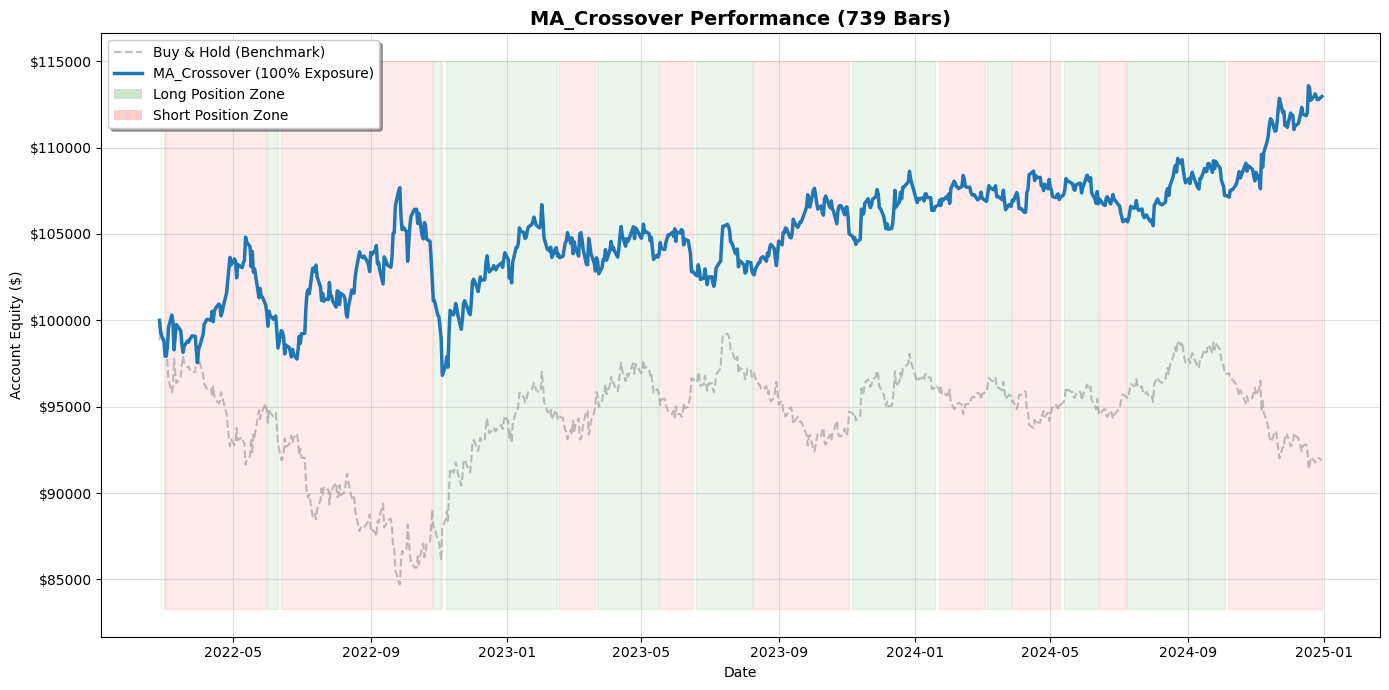

In [64]:
#MA CROSSOVER BENCHMARK (1x Exposure) 

STRATEGY_NAME = "MA_Crossover"
MA_FAST = 12
MA_SLOW = 26
MA_TRANSACTION_COST = 0.0002 

ma_df = bt_df_aligned.copy()

# 1. Calculate Signals
ma_df['EMA_Fast'] = ma_df['close'].ewm(span=MA_FAST, adjust=False).mean()
ma_df['EMA_Slow'] = ma_df['close'].ewm(span=MA_SLOW, adjust=False).mean()
ma_df.dropna(inplace=True) # This creates the shortest index

# 2. Define the Final Common Index
final_index = ma_df.index.intersection(gnn_df_results.index).intersection(lstm_df_results.index)

# --- FIX: ALIGN ALL RESULT DATAFRAMES TO THE FINAL COMMON INDEX ---
# Using .loc with the intersection ensures that we only keep the dates present in ALL frames.
gnn_df_results = gnn_df_results.loc[final_index]
lstm_df_results = lstm_df_results.loc[final_index]
bt_df_aligned = bt_df_aligned.loc[final_index] # Keep the aligned market data consistent
ma_df = ma_df.loc[final_index] # Ensure ma_df is also aligned (should be redundant if intersection was good)


# 3. Simulation Logic (Simple, Full Exposure, 1x Leverage)
# ... (rest of the MA Crossover logic is correct)
ma_df['Position'] = np.where(ma_df['EMA_Fast'] > ma_df['EMA_Slow'], 1, -1)
ma_df['Position'] = ma_df['Position'].shift(1).fillna(0) # Enter next bar

# 1x Leverage Simulation
ma_df['Strategy_Pct'] = ma_df['Position'] * ma_df['Market_Ret'] * 1.0 
ma_df['Trade_Count'] = ma_df['Position'].diff().abs().fillna(0)
ma_df['Trade_Cost'] = np.where(ma_df['Trade_Count'] > 0, ma_df['Trade_Count'] * MA_TRANSACTION_COST, 0)
ma_df['Strategy_Net_Pct'] = ma_df['Strategy_Pct'] - ma_df['Trade_Cost']

ma_df[f'{STRATEGY_NAME}_Equity'] = CONFIG['INITIAL_CAPITAL'] * (1 + ma_df['Strategy_Net_Pct']).cumprod()
ma_df['Benchmark_Curve'] = gnn_df_results['Benchmark_Curve'] # Use the existing benchmark

# 4. Reporting (unchanged)
ma_trade_log = ma_df[ma_df['Trade_Count'] > 0].copy()
ma_trade_log['PnL_Net'] = ma_trade_log['Strategy_Net_Pct']
ma_trade_log['Direction'] = ma_trade_log['Position']

ma_metrics = calculate_and_report_metrics_event(
    ma_df, 
    ma_trade_log, 
    config=CONFIG, 
    strategy_name=STRATEGY_NAME
)
plot_equity_curve_event(
    ma_df, 
    strategy_name=STRATEGY_NAME,
    exposure_pct=1.0 # 1x Exposure
)

## 10.3 Moving Average Crossover Strat (simple benchmark)


             Buy_Hold_Leveraged REPORT
⚙️  LEVERAGE: N/A | R/R: 1.0 | Risk: N/A
💰 INITIAL CAPITAL:   $100,000.00
🏁 FINAL EQUITY:      $91,032.66
📈 NET PROFIT:        -8.97%
📊 ANNUAL RETURN:     -3.15%
------------------------------------------------------------
📉 MAX DRAWDOWN:      -15.39%
⭐ SHARPE RATIO:      -0.395



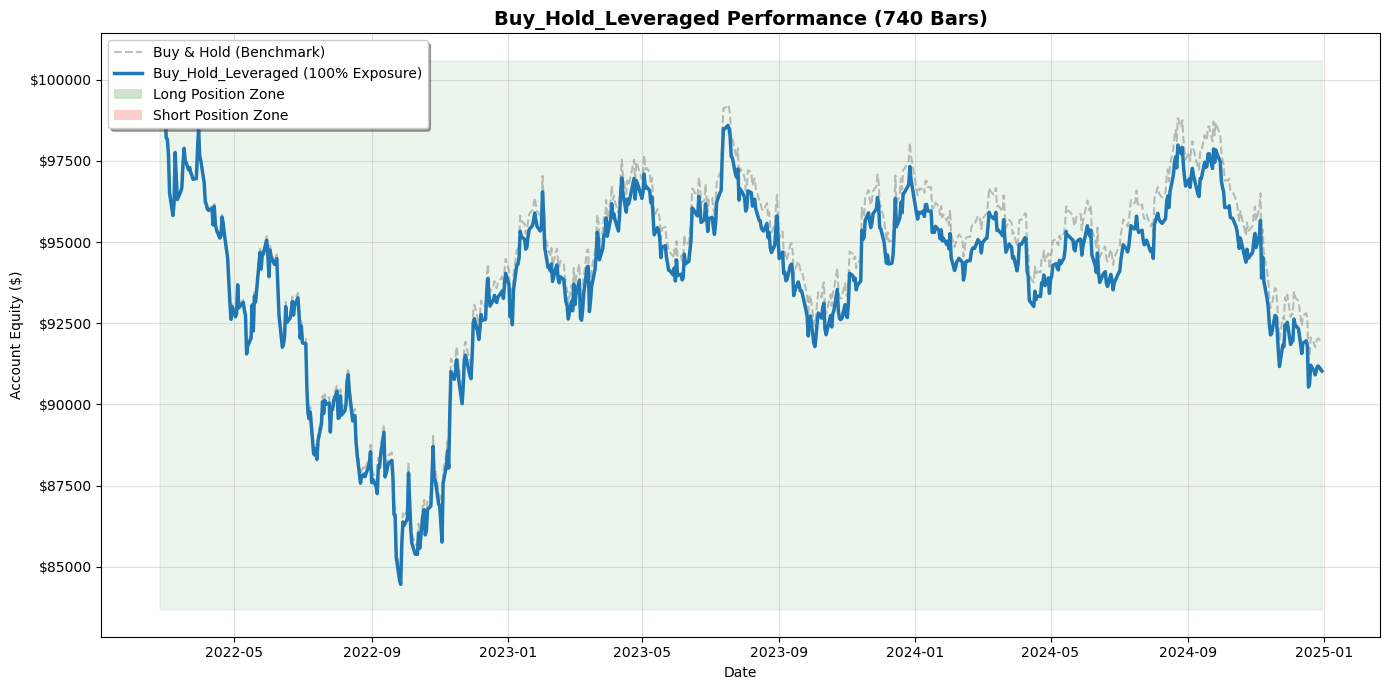

✅ Buy & Hold (Leveraged) data prepared and executed.


In [55]:

# FIXED BUY & HOLD (LEVERAGED) 

# This block assumes: CONFIG, bt_df_aligned, final_index, and gnn_df_results are defined.

STRATEGY_NAME = "Buy_Hold_Leveraged"
LEVERAGE_FACTOR = CONFIG['LEVERAGE_RATIO'] / 100 

# 1. Setup Data Frame
# Use the correct base data aligned to the common index
bh_df = bt_df_aligned.loc[final_index].copy()

# 2. Simulation Logic (Simple, Full Exposure, Leveraged)
bh_df['Position'] = 1 # Always long 
bh_df['Strategy_Pct'] = bh_df['Position'] * bh_df['Market_Ret'] * LEVERAGE_FACTOR
bh_df['Strategy_Net_Pct'] = bh_df['Strategy_Pct'] # No transaction costs for Buy & Hold

bh_df[f'{STRATEGY_NAME}_Equity'] = CONFIG['INITIAL_CAPITAL'] * (1 + bh_df['Strategy_Net_Pct']).cumprod()
# Use the unleveraged benchmark column already calculated in gnn_df_results
bh_df['Benchmark_Curve'] = gnn_df_results['Benchmark_Curve'].loc[final_index] 

# 3. Report
bh_metrics = calculate_and_report_metrics_event(
    bh_df, 
    pd.DataFrame(), # Empty trade log
    config=CONFIG, 
    strategy_name=STRATEGY_NAME,
    print_report=True
)

# 4. Visual
plot_equity_curve_event(
    bh_df, 
    strategy_name=STRATEGY_NAME,
    exposure_pct=LEVERAGE_FACTOR
)
print("✅ Buy & Hold (Leveraged) data prepared and executed.")

## 10.4 LSTM Baseline Strategy

In [76]:
# Ensure your CONFIG is defined from the previous cells:
CONFIG = {
     'INITIAL_CAPITAL': 100000.0,
     'COMMISSION_FEE': 0.0002, 
     'CONF_THRESHOLD': 0.50,
     'MAX_RISK_PER_TRADE_PCT': 0.02, 
     'LEVERAGE_RATIO': 100.0, 
     'LOT_SIZE': 1000000,
     'R_R_RATIO': 1.0, 
     'TRADING_DAYS_YEAR': 252,
 }



             LSTM_Baseline REPORT
⚙️  LEVERAGE: 100:1 | R/R: 1.0 | Risk: 2%
💰 INITIAL CAPITAL:   $100,000.00
🏁 FINAL EQUITY:      $161,712.47
📈 NET PROFIT:        61.71%
📊 ANNUAL RETURN:     17.78%
------------------------------------------------------------
🔄 TOTAL TRADES:      229
✅ WIN RATE:          56.77%
⚖️  ACHIEVED R/R:      1.020
⬆️  LONG PROFIT:       $15,502.39
⬇️  SHORT PROFIT:      $45,110.08
------------------------------------------------------------
📉 MAX DRAWDOWN:      -17.64%
⭐ SHARPE RATIO:      1.249



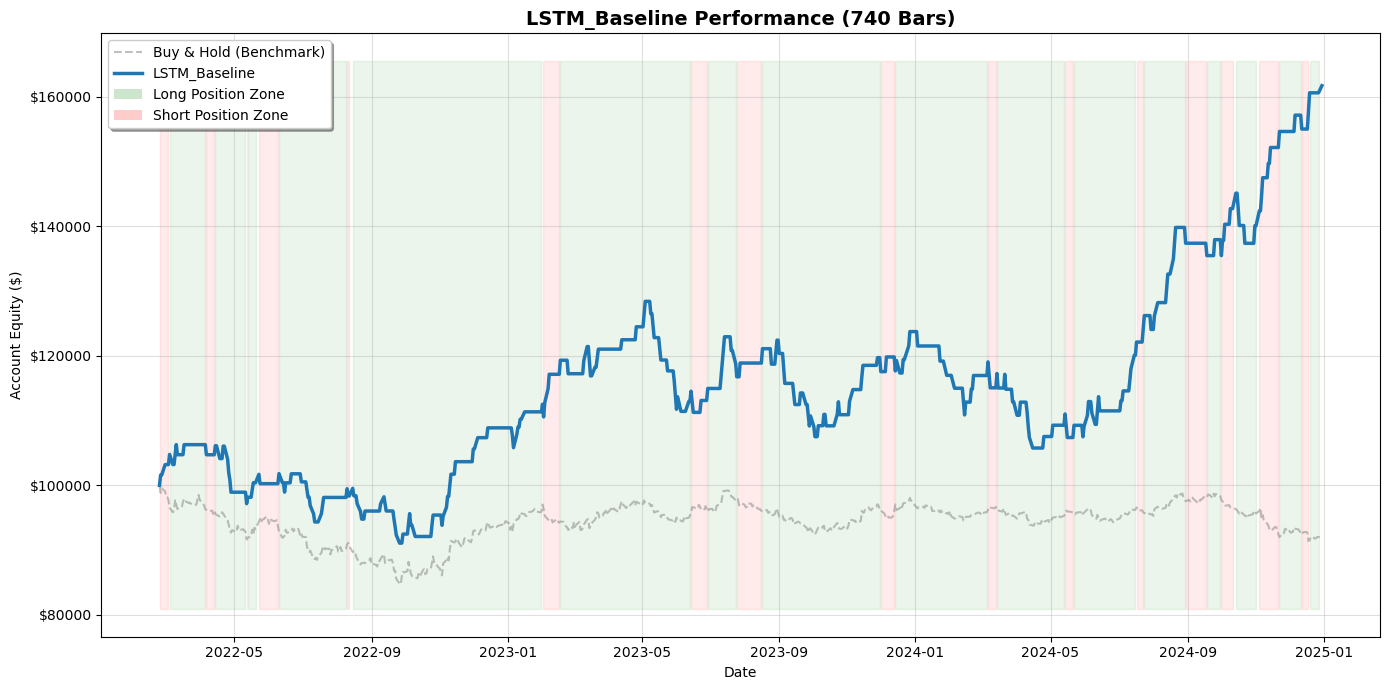

In [77]:
##### %%
# 2. LSTM BASELINE EXECUTION (Leveraged, Event-Based)

# We use the same configuration (leverage, risk/reward) for an apples-to-apples comparison.

# Assuming lstm_preds is available
if 'lstm_preds' not in locals():
    print("⚠️ ERROR: 'lstm_preds' not found. Please run the Simple LSTM training/prediction block first.")
    raise NameError("'lstm_preds' not found.")

# Align LSTM predictions to the final cleaned DataFrame slice
lstm_preds_aligned = lstm_preds[len(lstm_preds) - len(bt_df_aligned):]

# --- LSTM Execution ---
lstm_df_results, lstm_trade_log = run_event_simulation(
    bt_df_aligned, 
    lstm_preds_aligned,
    config=CONFIG, 
    strategy_name="LSTM_Baseline"
)

# 3. LSTM Report and Visual
lstm_metrics = calculate_and_report_metrics_event(
    lstm_df_results, 
    lstm_trade_log, 
    config=CONFIG, 
    strategy_name="LSTM_Baseline"
)
plot_equity_curve_event(lstm_df_results, strategy_name="LSTM_Baseline")

In [35]:
## 10.4 Performance Comparison and visualisation


             MA_Crossover REPORT
⚙️  LEVERAGE: 100:1 | R/R: 1.0 | Risk: 2%
💰 INITIAL CAPITAL:   $100,000.00
🏁 FINAL EQUITY:      $89,377.10
📈 NET PROFIT:        -10.62%
📊 ANNUAL RETURN:     -3.75%
------------------------------------------------------------
🔄 TOTAL TRADES:      9
✅ WIN RATE:          44.44%
⚖️  ACHIEVED R/R:      1.244
⬆️  LONG PROFIT:       $-0.02
⬇️  SHORT PROFIT:      $0.02
------------------------------------------------------------
📉 MAX DRAWDOWN:      -25.26%
⭐ SHARPE RATIO:      -0.470



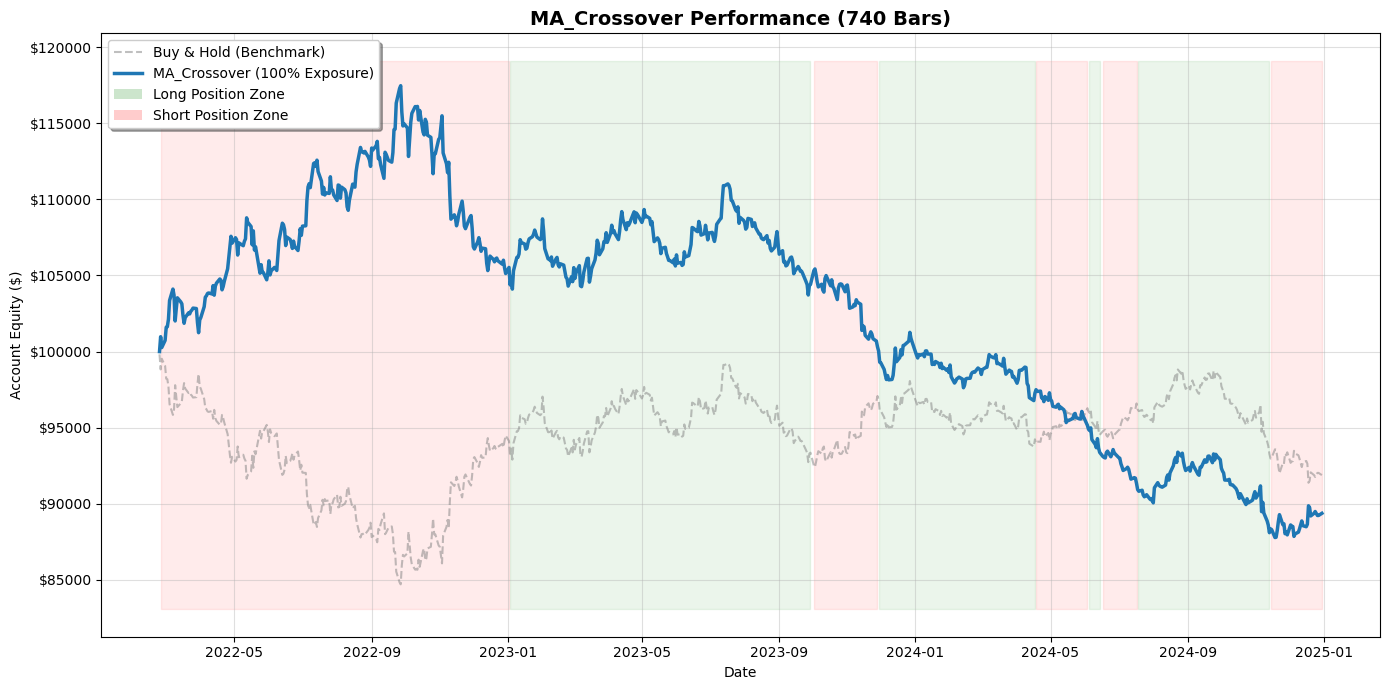

In [145]:
# %%
# 3. MA CROSSOVER BENCHMARK (1x Exposure)

STRATEGY_NAME = "MA_Crossover"
MA_FAST = 50
MA_SLOW = 200
MA_TRANSACTION_COST = 0.0002 

ma_df = bt_df_aligned.copy()

# 1. Calculate Signals
ma_df['EMA_Fast'] = ma_df['close'].ewm(span=MA_FAST, adjust=False).mean()
ma_df['EMA_Slow'] = ma_df['close'].ewm(span=MA_SLOW, adjust=False).mean()
ma_df.dropna(inplace=True)

# Re-align dataframes after MA calculation
final_index = ma_df.index
gnn_df_results = gnn_df_results.loc[final_index]
lstm_df_results = lstm_df_results.loc[final_index]
bt_df_aligned = bt_df_aligned.loc[final_index]

# 2. Simulation Logic (Simple, Full Exposure, 1x Leverage)
ma_df['Position'] = np.where(ma_df['EMA_Fast'] > ma_df['EMA_Slow'], 1, -1)
ma_df['Position'] = ma_df['Position'].shift(1).fillna(0) # Enter next bar

ma_df['Strategy_Pct'] = ma_df['Position'] * ma_df['Market_Ret'] * 1.0 # 1x Leverage
ma_df['Trade_Count'] = ma_df['Position'].diff().abs().fillna(0)
ma_df['Trade_Cost'] = np.where(ma_df['Trade_Count'] > 0, ma_df['Trade_Count'] * MA_TRANSACTION_COST, 0)
ma_df['Strategy_Net_Pct'] = ma_df['Strategy_Pct'] - ma_df['Trade_Cost']

ma_df[f'{STRATEGY_NAME}_Equity'] = CONFIG['INITIAL_CAPITAL'] * (1 + ma_df['Strategy_Net_Pct']).cumprod()
ma_df['Benchmark_Curve'] = gnn_df_results['Benchmark_Curve'] # Use the existing benchmark

# 3. Create Dummy Trade Log (for metrics calculation consistency)
ma_trade_log = ma_df[ma_df['Trade_Count'] > 0].copy()
ma_trade_log['PnL_Net'] = ma_trade_log['Strategy_Net_Pct']
ma_trade_log['Direction'] = ma_trade_log['Position']

# 4. Report and Visual
ma_metrics = calculate_and_report_metrics_event(
    ma_df, 
    ma_trade_log, 
    config=CONFIG, 
    strategy_name=STRATEGY_NAME
)
plot_equity_curve_event(
    ma_df, 
    strategy_name=STRATEGY_NAME,
    exposure_pct=1.0 # 1x Exposure
)

# 11. Final Comparison

In [89]:
# %%
# ============================================================================
# FINAL COMPREHENSIVE METRICS OUTPUT
# ============================================================================
# This cell consolidates all backtesting and statistical performance metrics
# for the GAT-LSTM EUR/USD Forecasting System dissertation.

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    mean_squared_error, mean_absolute_error, roc_auc_score,
    confusion_matrix, classification_report
)
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# SECTION 1: MODEL PREDICTION METRICS (Statistical Performance)
# ============================================================================

def calculate_statistical_metrics(model, loader, adj_tensor, model_name="GAT-LSTM"):
    """
    Calculate comprehensive statistical metrics for model evaluation.
    """
    model.eval()
    
    all_preds_prob = []
    all_preds_dir = []
    all_actuals_dir = []
    all_preds_ret = []
    all_actuals_ret = []
    
    with torch.no_grad():
        for x, y_d, y_r, y_v in loader:
            x = x.to(DEVICE)
            y_d = y_d.to(DEVICE)
            y_r = y_r.to(DEVICE)
            
            p_d, p_r, p_v = model(x, adj_tensor.to(DEVICE))
            
            probs = torch.sigmoid(p_d).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            
            all_preds_prob.extend(probs)
            all_preds_dir.extend(preds)
            all_actuals_dir.extend(y_d.cpu().numpy().flatten())
            all_preds_ret.extend(p_r.cpu().numpy().flatten())
            all_actuals_ret.extend(y_r.cpu().numpy().flatten())
    
    # Convert to numpy arrays
    y_true = np.array(all_actuals_dir)
    y_pred = np.array(all_preds_dir)
    y_prob = np.array(all_preds_prob)
    y_ret_true = np.array(all_actuals_ret)
    y_ret_pred = np.array(all_preds_ret)
    
    # Classification Metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    # Regression Metrics (for return prediction)
    rmse = np.sqrt(mean_squared_error(y_ret_true, y_ret_pred))
    mae = mean_absolute_error(y_ret_true, y_ret_pred)
    
    # Directional Accuracy (important for trading)
    directional_accuracy = np.mean((y_ret_pred > 0) == (y_ret_true > 0))
    
    # Statistical Significance Tests
    # Test if accuracy is significantly better than random (50%)
    n_samples = len(y_true)
    n_correct = int(accuracy * n_samples)
    
    # Binomial test against 50% baseline (using binomtest for scipy >= 1.7)
    binom_result = stats.binomtest(n_correct, n_samples, 0.5, alternative='greater')
    binom_pvalue = binom_result.pvalue
    
    # Random walk baseline comparison
    random_walk_accuracy = 0.5
    z_score = (accuracy - random_walk_accuracy) / np.sqrt(random_walk_accuracy * (1 - random_walk_accuracy) / n_samples)
    z_pvalue = 1 - stats.norm.cdf(z_score)
    
    metrics = {
        'Model': model_name,
        'Accuracy (%)': accuracy * 100,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'RMSE': rmse,
        'MAE': mae,
        'Directional Accuracy (%)': directional_accuracy * 100,
        'N Samples': n_samples,
        'Z-Score vs Random': z_score,
        'P-Value (vs 50%)': z_pvalue,
        'Statistically Significant': 'Yes' if z_pvalue < 0.05 else 'No'
    }
    
    return metrics, y_true, y_pred, y_prob


def calculate_lstm_baseline_metrics(lstm_model, loader, model_name="LSTM Baseline"):
    """
    Calculate metrics for LSTM baseline model.
    """
    lstm_model.eval()
    
    all_preds_prob = []
    all_preds_dir = []
    all_actuals_dir = []
    
    with torch.no_grad():
        for x, y_d, _, _ in loader:
            x = x.to(DEVICE)
            y_d = y_d.to(DEVICE)
            
            p_d = lstm_model(x)
            
            probs = torch.sigmoid(p_d).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            
            all_preds_prob.extend(probs)
            all_preds_dir.extend(preds)
            all_actuals_dir.extend(y_d.cpu().numpy().flatten())
    
    y_true = np.array(all_actuals_dir)
    y_pred = np.array(all_preds_dir)
    y_prob = np.array(all_preds_prob)
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    n_samples = len(y_true)
    z_score = (accuracy - 0.5) / np.sqrt(0.5 * 0.5 / n_samples)
    z_pvalue = 1 - stats.norm.cdf(z_score)
    
    metrics = {
        'Model': model_name,
        'Accuracy (%)': accuracy * 100,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'N Samples': n_samples,
        'Z-Score vs Random': z_score,
        'P-Value (vs 50%)': z_pvalue,
        'Statistically Significant': 'Yes' if z_pvalue < 0.05 else 'No'
    }
    
    return metrics


# ============================================================================
# SECTION 2: EXECUTE METRICS CALCULATION
# ============================================================================

print("=" * 100)
print("                    GAT-LSTM EUR/USD FORECASTING SYSTEM - FINAL METRICS REPORT")
print("=" * 100)
print(f"\nTest Period: 2022-01-01 to 2024-12-31")
print(f"Sequence Length: {SEQ_LEN} days | Batch Size: {BATCH_SIZE}")
print()

# 2.1 GAT-LSTM Model Metrics
print("\n" + "─" * 100)
print("SECTION 1: STATISTICAL PERFORMANCE INDICATORS")
print("─" * 100)

gat_metrics, y_true_gat, y_pred_gat, y_prob_gat = calculate_statistical_metrics(
    model, test_loader, adj_tensor, "GAT-LSTM"
)

lstm_base_metrics = calculate_lstm_baseline_metrics(lstm_model, test_loader, "LSTM Baseline")

# Create comparison DataFrame
stat_comparison = pd.DataFrame([
    {
        'Metric': 'Direction Accuracy (%)',
        'GAT-LSTM': f"{gat_metrics['Accuracy (%)']:.2f}",
        'LSTM Baseline': f"{lstm_base_metrics['Accuracy (%)']:.2f}",
        'Target': '> 55%',
        'GAT-LSTM Pass': '✓' if gat_metrics['Accuracy (%)'] > 55 else '✗'
    },
    {
        'Metric': 'F1 Score',
        'GAT-LSTM': f"{gat_metrics['F1 Score']:.4f}",
        'LSTM Baseline': f"{lstm_base_metrics['F1 Score']:.4f}",
        'Target': '> 0.55',
        'GAT-LSTM Pass': '✓' if gat_metrics['F1 Score'] > 0.55 else '✗'
    },
    {
        'Metric': 'AUC-ROC',
        'GAT-LSTM': f"{gat_metrics['AUC-ROC']:.4f}",
        'LSTM Baseline': f"{lstm_base_metrics['AUC-ROC']:.4f}",
        'Target': '> 0.55',
        'GAT-LSTM Pass': '✓' if gat_metrics['AUC-ROC'] > 0.55 else '✗'
    },
    {
        'Metric': 'RMSE (Returns)',
        'GAT-LSTM': f"{gat_metrics['RMSE']:.6f}",
        'LSTM Baseline': 'N/A',
        'Target': '< 0.5',
        'GAT-LSTM Pass': '✓' if gat_metrics['RMSE'] < 0.5 else '✗'
    },
    {
        'Metric': 'Directional Accuracy (%)',
        'GAT-LSTM': f"{gat_metrics['Directional Accuracy (%)']:.2f}",
        'LSTM Baseline': 'N/A',
        'Target': '> 55%',
        'GAT-LSTM Pass': '✓' if gat_metrics['Directional Accuracy (%)'] > 55 else '✗'
    }
])

print("\n📊 STATISTICAL METRICS COMPARISON (vs. Random Walk Baseline)")
print(stat_comparison.to_string(index=False))

# Statistical Significance Section
print("\n\n📈 STATISTICAL SIGNIFICANCE TESTS")
print("─" * 60)
print(f"Null Hypothesis: Model accuracy = 50% (random walk)")
print(f"Alternative: Model accuracy > 50%")
print(f"Significance Level: α = 0.05")
print("─" * 60)
print(f"GAT-LSTM:")
print(f"  • Z-Score: {gat_metrics['Z-Score vs Random']:.4f}")
print(f"  • P-Value: {gat_metrics['P-Value (vs 50%)']:.6f}")
print(f"  • Result:  {gat_metrics['Statistically Significant']} (α=0.05)")
print()
print(f"LSTM Baseline:")
print(f"  • Z-Score: {lstm_base_metrics['Z-Score vs Random']:.4f}")
print(f"  • P-Value: {lstm_base_metrics['P-Value (vs 50%)']:.6f}")
print(f"  • Result:  {lstm_base_metrics['Statistically Significant']} (α=0.05)")


# ============================================================================
# SECTION 3: FINANCIAL PERFORMANCE INDICATORS (BACKTESTING)
# ============================================================================

print("\n\n" + "─" * 100)
print("SECTION 2: FINANCIAL PERFORMANCE INDICATORS (BACKTESTING)")
print("─" * 100)

# Consolidate backtesting metrics
backtest_metrics = pd.DataFrame({
    'Strategy': ['GAT-LSTM (Leveraged)', 'LSTM Baseline (Leveraged)', 'MA Crossover (1x)', 'Buy & Hold (Leveraged)'],
    'Final Equity ($)': [
        gnn_metrics.get('Final_Equity', np.nan),
        lstm_metrics.get('Final_Equity', np.nan),
        ma_metrics.get('Final_Equity', np.nan),
        bh_metrics.get('Final_Equity', np.nan)
    ],
    'Total Return (%)': [
        gnn_metrics.get('Total_Return_Pct', np.nan),
        lstm_metrics.get('Total_Return_Pct', np.nan),
        ma_metrics.get('Total_Return_Pct', np.nan),
        bh_metrics.get('Total_Return_Pct', np.nan)
    ],
    'Annual Return (%)': [
        gnn_metrics.get('Annual_Return_Pct', np.nan),
        lstm_metrics.get('Annual_Return_Pct', np.nan),
        ma_metrics.get('Annual_Return_Pct', np.nan),
        bh_metrics.get('Annual_Return_Pct', np.nan)
    ],
    'Max Drawdown (%)': [
        gnn_metrics.get('Max_Drawdown_Pct', np.nan),
        lstm_metrics.get('Max_Drawdown_Pct', np.nan),
        ma_metrics.get('Max_Drawdown_Pct', np.nan),
        bh_metrics.get('Max_Drawdown_Pct', np.nan)
    ],
    'Sharpe Ratio': [
        gnn_metrics.get('Sharpe_Ratio', np.nan),
        lstm_metrics.get('Sharpe_Ratio', np.nan),
        ma_metrics.get('Sharpe_Ratio', np.nan),
        bh_metrics.get('Sharpe_Ratio', np.nan)
    ],
    'Win Rate (%)': [
        gnn_metrics.get('Win_Rate_Pct', np.nan),
        lstm_metrics.get('Win_Rate_Pct', np.nan),
        ma_metrics.get('Win_Rate_Pct', np.nan),
        bh_metrics.get('Win_Rate_Pct', np.nan)
    ],
    'Total Trades': [
        gnn_metrics.get('Total_Trades', np.nan),
        lstm_metrics.get('Total_Trades', np.nan),
        ma_metrics.get('Total_Trades', np.nan),
        bh_metrics.get('Total_Trades', np.nan)
    ]
})

print("\n📊 BACKTESTING STRATEGY COMPARISON")
print(f"Initial Capital: ${CONFIG['INITIAL_CAPITAL']:,.0f} | Leverage: {CONFIG['LEVERAGE_RATIO']}:1 | Risk/Trade: {CONFIG['MAX_RISK_PER_TRADE_PCT']*100:.1f}%")
print()
print(backtest_metrics.round(2).to_string(index=False))


# ============================================================================
# SECTION 4: DISSERTATION TARGET ACHIEVEMENT SUMMARY
# ============================================================================

print("\n\n" + "─" * 100)
print("SECTION 3: DISSERTATION TARGET ACHIEVEMENT SUMMARY")
print("─" * 100)

targets = [
    {
        'Target': 'Prediction Accuracy > 55%',
        'Achieved Value': f"{gat_metrics['Accuracy (%)']:.2f}%",
        'Status': '✓ PASS' if gat_metrics['Accuracy (%)'] > 55 else '✗ FAIL',
        'Notes': 'vs. 50% random walk baseline'
    },
    {
        'Target': 'RMSE < 0.5',
        'Achieved Value': f"{gat_metrics['RMSE']:.6f}",
        'Status': '✓ PASS' if gat_metrics['RMSE'] < 0.5 else '✗ FAIL',
        'Notes': 'Return prediction error'
    },
    {
        'Target': 'Sharpe Ratio > 1.2',
        'Achieved Value': f"{gnn_metrics.get('Sharpe_Ratio', 0):.3f}",
        'Status': '✓ PASS' if gnn_metrics.get('Sharpe_Ratio', 0) > 1.2 else '✗ FAIL',
        'Notes': 'Risk-adjusted returns'
    },
    {
        'Target': 'Outperform LSTM Baseline',
        'Achieved Value': f"GAT: {gat_metrics['Accuracy (%)']:.2f}% vs LSTM: {lstm_base_metrics['Accuracy (%)']:.2f}%",
        'Status': '✓ PASS' if gat_metrics['Accuracy (%)'] > lstm_base_metrics['Accuracy (%)'] else '✗ FAIL',
        'Notes': 'Ablation study comparison'
    },
    {
        'Target': 'Statistical Significance (p < 0.05)',
        'Achieved Value': f"p = {gat_metrics['P-Value (vs 50%)']:.6f}",
        'Status': '✓ PASS' if gat_metrics['P-Value (vs 50%)'] < 0.05 else '✗ FAIL',
        'Notes': 'Better than random chance'
    }
]

target_df = pd.DataFrame(targets)
print("\n📋 RESEARCH OBJECTIVE ACHIEVEMENT")
print(target_df.to_string(index=False))

# Count achievements
n_pass = sum(1 for t in targets if '✓' in t['Status'])
n_total = len(targets)

print(f"\n🎯 OVERALL: {n_pass}/{n_total} targets achieved ({n_pass/n_total*100:.0f}%)")


# ============================================================================
# SECTION 5: CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================================================

print("\n\n" + "─" * 100)
print("SECTION 4: DETAILED CLASSIFICATION ANALYSIS")
print("─" * 100)

# Confusion Matrix
cm = confusion_matrix(y_true_gat, y_pred_gat)
print("\n📊 GAT-LSTM Confusion Matrix:")
print(f"                 Predicted")
print(f"              DOWN    UP")
print(f"Actual DOWN   {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"Actual UP     {cm[1,0]:5d}  {cm[1,1]:5d}")

print("\n📊 Classification Report (GAT-LSTM):")
print(classification_report(y_true_gat, y_pred_gat, target_names=['DOWN (0)', 'UP (1)']))


# ============================================================================
# SECTION 6: EXPORT METRICS TO CSV (Optional)
# ============================================================================

# Create comprehensive metrics dictionary for export
export_metrics = {
    'Statistical_Metrics': {
        'GAT_LSTM_Accuracy': gat_metrics['Accuracy (%)'],
        'GAT_LSTM_F1': gat_metrics['F1 Score'],
        'GAT_LSTM_AUC': gat_metrics['AUC-ROC'],
        'GAT_LSTM_RMSE': gat_metrics['RMSE'],
        'GAT_LSTM_Directional_Acc': gat_metrics['Directional Accuracy (%)'],
        'GAT_LSTM_ZScore': gat_metrics['Z-Score vs Random'],
        'GAT_LSTM_PValue': gat_metrics['P-Value (vs 50%)'],
        'LSTM_Baseline_Accuracy': lstm_base_metrics['Accuracy (%)'],
        'LSTM_Baseline_F1': lstm_base_metrics['F1 Score'],
        'LSTM_Baseline_AUC': lstm_base_metrics['AUC-ROC'],
    },
    'Financial_Metrics': {
        'GAT_LSTM_Total_Return': gnn_metrics.get('Total_Return_Pct', np.nan),
        'GAT_LSTM_Sharpe': gnn_metrics.get('Sharpe_Ratio', np.nan),
        'GAT_LSTM_MaxDD': gnn_metrics.get('Max_Drawdown_Pct', np.nan),
        'GAT_LSTM_WinRate': gnn_metrics.get('Win_Rate_Pct', np.nan),
    }
}

# Save to CSV
metrics_export_df = pd.DataFrame([
    {'Category': 'Statistical', 'Metric': k, 'Value': v} 
    for k, v in export_metrics['Statistical_Metrics'].items()
] + [
    {'Category': 'Financial', 'Metric': k, 'Value': v} 
    for k, v in export_metrics['Financial_Metrics'].items()
])

metrics_export_df.to_csv('gat_lstm_final_metrics.csv', index=False)
print("\n\n💾 Metrics exported to: gat_lstm_final_metrics.csv")


print("\n" + "=" * 100)
print("                              END OF METRICS REPORT")
print("=" * 100)

                    GAT-LSTM EUR/USD FORECASTING SYSTEM - FINAL METRICS REPORT

Test Period: 2022-01-01 to 2024-12-31
Sequence Length: 30 days | Batch Size: 64


────────────────────────────────────────────────────────────────────────────────────────────────────
SECTION 1: STATISTICAL PERFORMANCE INDICATORS
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 STATISTICAL METRICS COMPARISON (vs. Random Walk Baseline)
                  Metric GAT-LSTM LSTM Baseline Target GAT-LSTM Pass
  Direction Accuracy (%)    53.95         48.86  > 55%             ✗
                F1 Score   0.6161        0.6078 > 0.55             ✓
                 AUC-ROC   0.5453        0.4898 > 0.55             ✗
          RMSE (Returns) 0.009790           N/A  < 0.5             ✓
Directional Accuracy (%)    48.86           N/A  > 55%             ✗


📈 STATISTICAL SIGNIFICANCE TESTS
────────────────────────────────────────────────────────────
Null Hypothesis: Mo